In [1]:
%matplotlib notebook
import numpy as np
import sigpy.plot as pl
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import lagrange
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths
from numpy.polynomial.polynomial import Polynomial

<h1> Time to Peak Color Map Project<h1>

In [2]:
#Load and deserialize numpy array 
mat = np.load("20190923_vo1_pr_rec_Jac_fit_workspace.npy", allow_pickle=True).item()
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'D', 'Jac', 'Jac_fit', 'Jac_max', 'insp_reg', 'invD', 'lung_mask'])

<IPython.core.display.Javascript object>


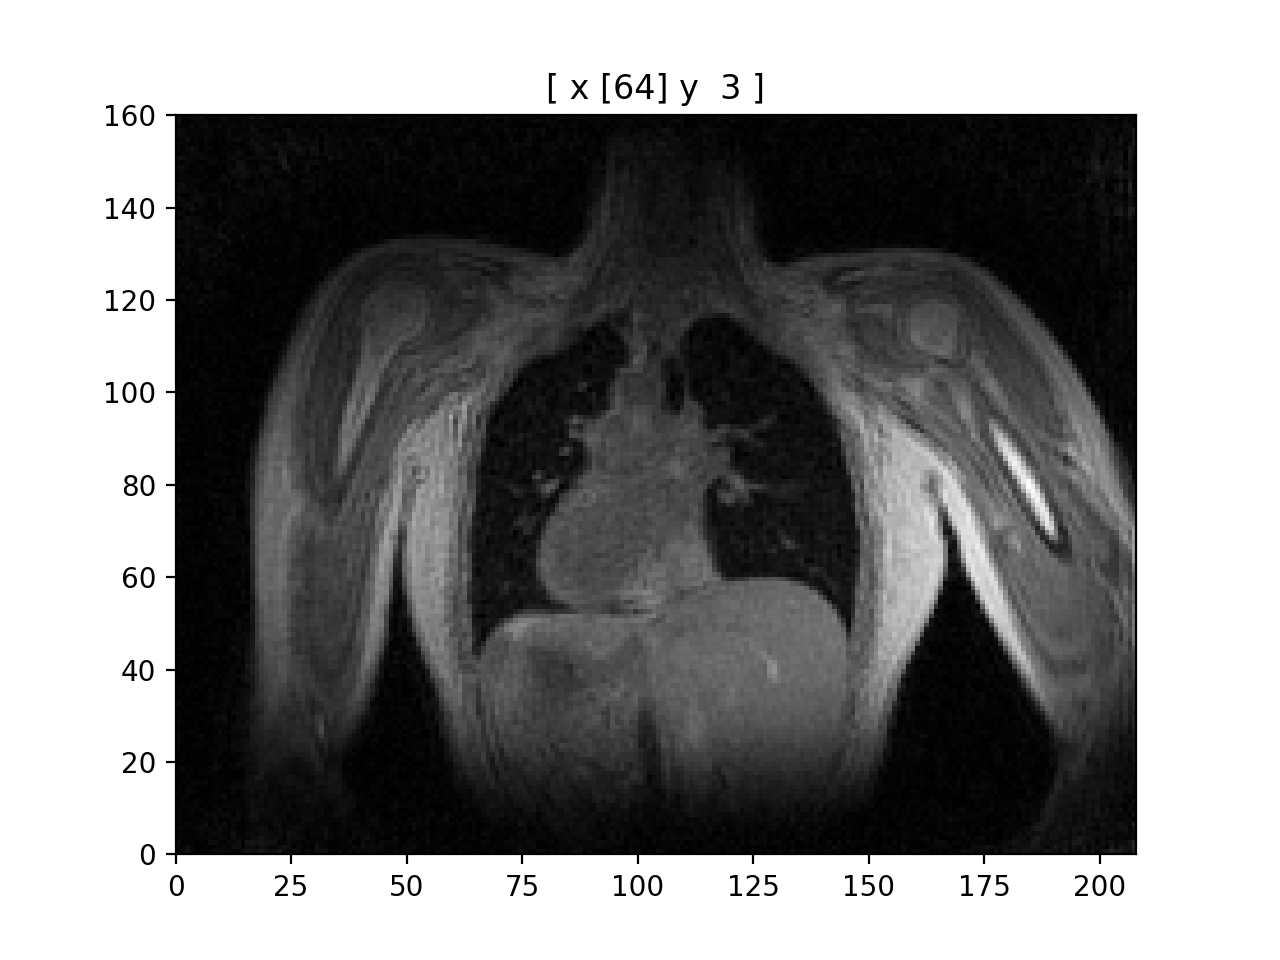

In [3]:
#Plot registered MRI image
registered = mat['insp_reg']
pl.ImagePlot(registered, x=0)

<h1> Curve Fitting for Time to Peak <h1>

In [4]:
#Define gaussian function
def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

In [5]:
#Computes lagrange polynomial values in [0,5]
def lagrange_curve_fitting(y_values, samples):
    lagrange_x = np.linspace(0,5,6)
    lagrange_y = y_values
    x = np.linspace(0,5,num=samples)
    poly = lagrange(lagrange_x, lagrange_y)
    lagrange_coef = Polynomial(poly).coef
    return x, poly(x)

In [6]:
#Plot time to peak intensity with lagrange curve fit 
def plot_TTP_langrange(intensity_values):
    lagrange_x, lagrange_y = lagrange_curve_fitting(intensity_values, 40)
    fig = plt.figure()
    plt.plot(np.arange(6), intensity_values, label='Intensity')
    plt.plot(lagrange_x, lagrange_y, label='Lagrange Polynomial')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [7]:
#Plot time to peak curve fit with full width at half maximum
def plot_full_width_half_max(intensity_values):
    lagrange_x, lagrange_y = lagrange_curve_fitting(intensity_values, 30)
    fig = plt.figure()
    plt.plot(lagrange_y, label='Lagrange Polynomial')
    peaks, _ = find_peaks(lagrange_y)
    results_half = peak_widths(lagrange_y, peaks, rel_height=0.5)
    plt.hlines(*results_half[1:], color="C2", label="Full Width at Half Max")
    plt.plot(peaks, lagrange_y[peaks], "x", label='Max')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [8]:
#Plot intensity values with gaussian curve fitting
#Input: An array of intensity values with length of 6

def plot_gaussian_curve_fit(intensity_values):
    time = np.arange(6)
    fitted_x, fitted_y = gaussian_curve_fitting(intensity_values)
    
    fig = plt.figure()
    plt.plot(time, intensity_values, "ob", label = "Measured")
    plt.plot(fitted_x, fitted_y,'r',label='Gaussian Curve Fit')
    plt.xticks(time)
    plt.title("Gaussian Curve Fitting")
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.grid()
    plt.legend()
    plt.show()

In [9]:
def gaussian_curve_fitting(intensity_values):
    n = 6 #len(intensity_values)
    data = intensity_values
    time = np.arange(6)
    
    mean = sum(data*time)/n
    sigma = np.sqrt(sum(data*(time-mean)**2)/n)
    popt,pcov = curve_fit(gaussian,time,data)
    fitted_x = np.linspace(0,5,20)
    fitted_y = gaussian(fitted_x,*popt)
    ttp_x = fitted_x[np.argmax(fitted_y)]
          
          
    return fitted_x, fitted_y

In [93]:
#Calculates time to peak for gaussian curve fitting
def calculate_time_to_peak_gaussian(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    data = img[i, j, k, :]
                    fitted_x, fitted_y = gaussian_curve_fitting(data)

                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

In [14]:
#Calculate intensity of of a given sample
def calculate_intensity(sample):
    intensity = np.array([])
    for i in range(sample.shape[3]):
        intensity = np.append(intensity, np.mean(sample[:,:,:,i:i+1]))
    return intensity

<IPython.core.display.Javascript object>


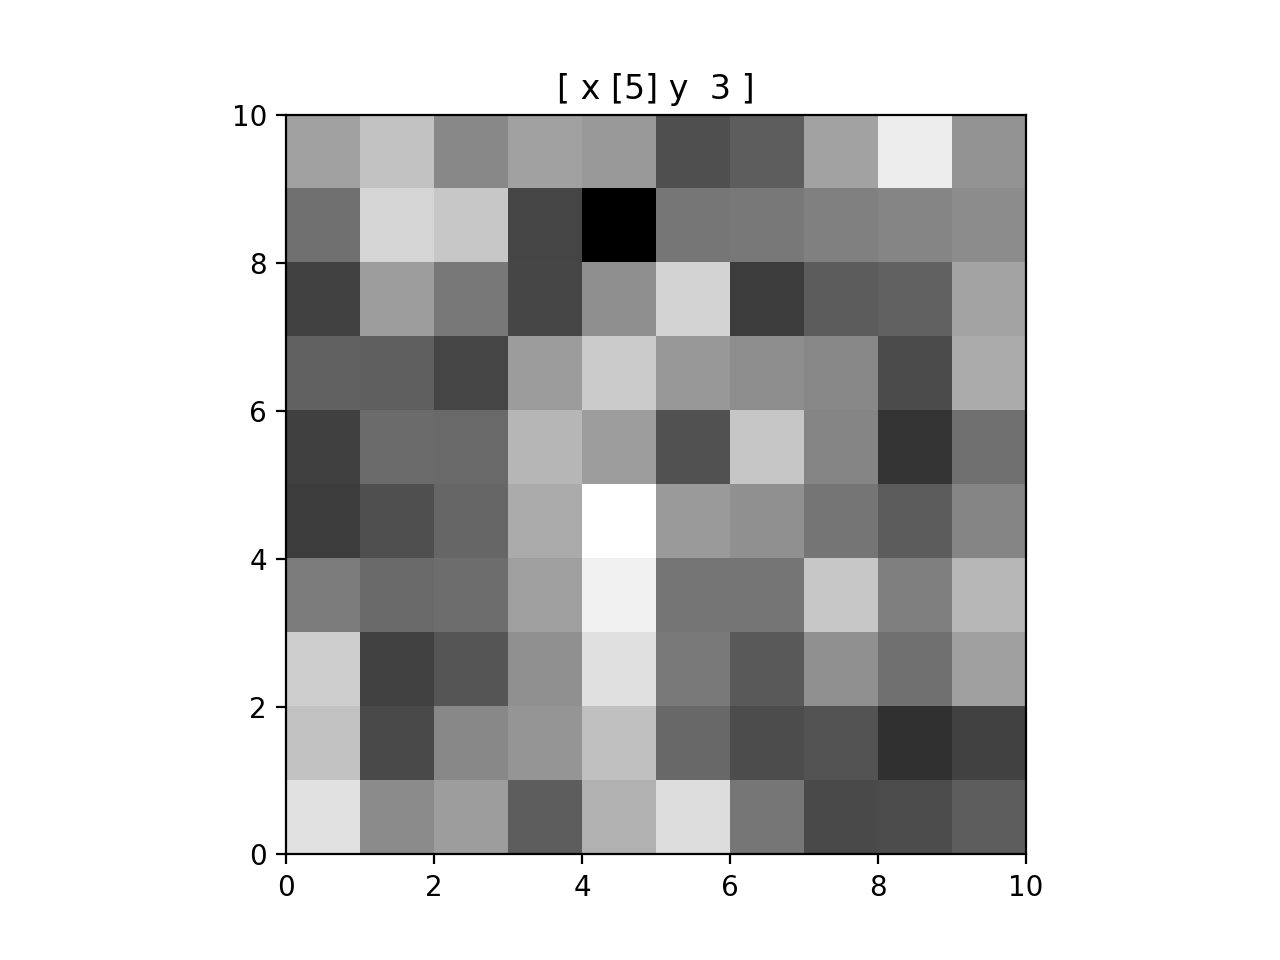

In [15]:
#10x10x10 voxel sample of the top right lung 
intensity_top_sample = registered[120:130,60:70,95:105,:]
pl.ImagePlot(intensity_top_sample, x=0)

<IPython.core.display.Javascript object>


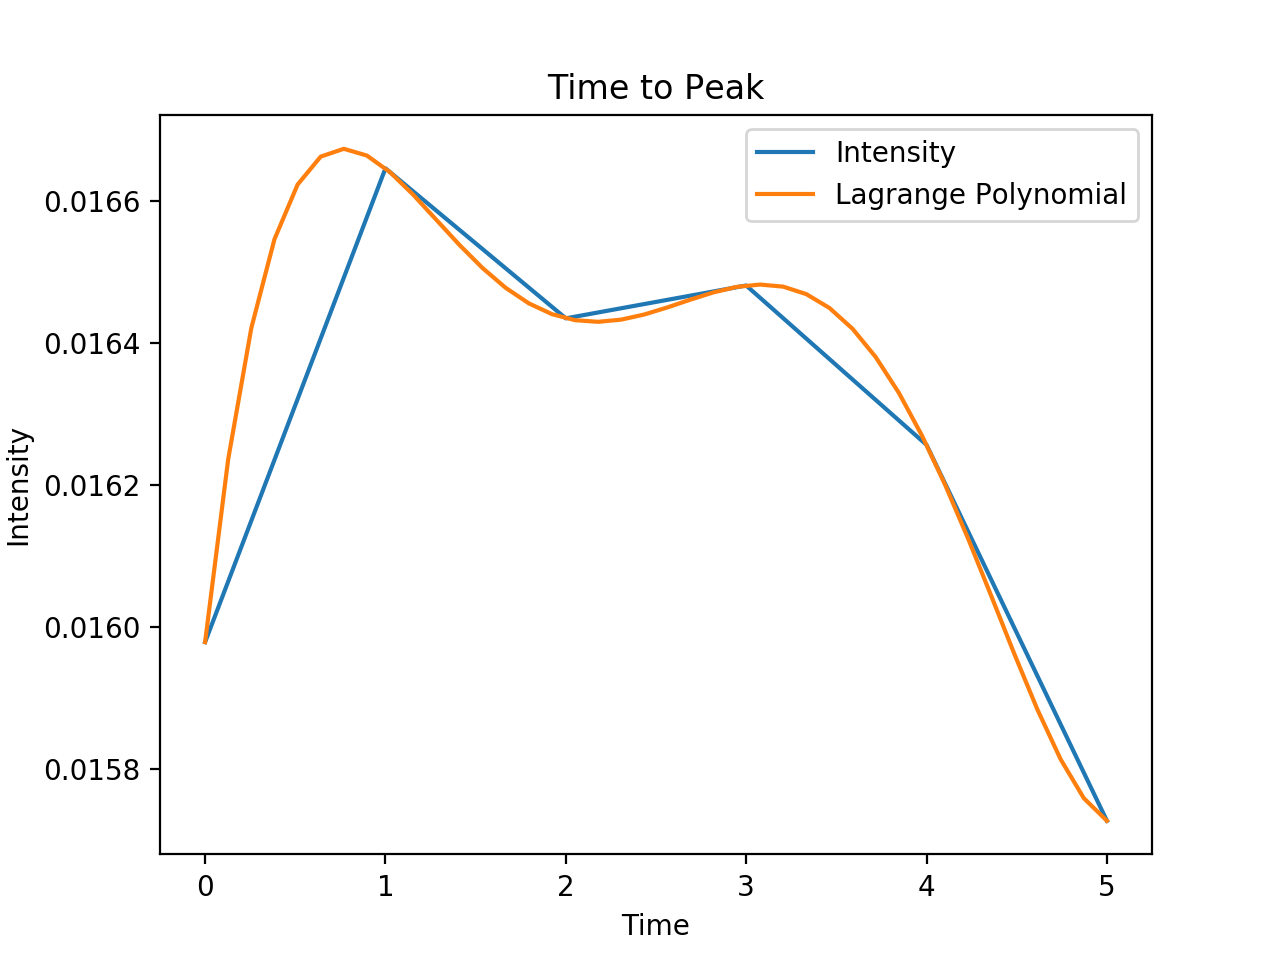

In [16]:
#Plot Time to Peak of top right sample
intensity_top_array = calculate_intensity(intensity_top_sample)
plot_TTP_langrange(intensity_top_array)

<IPython.core.display.Javascript object>


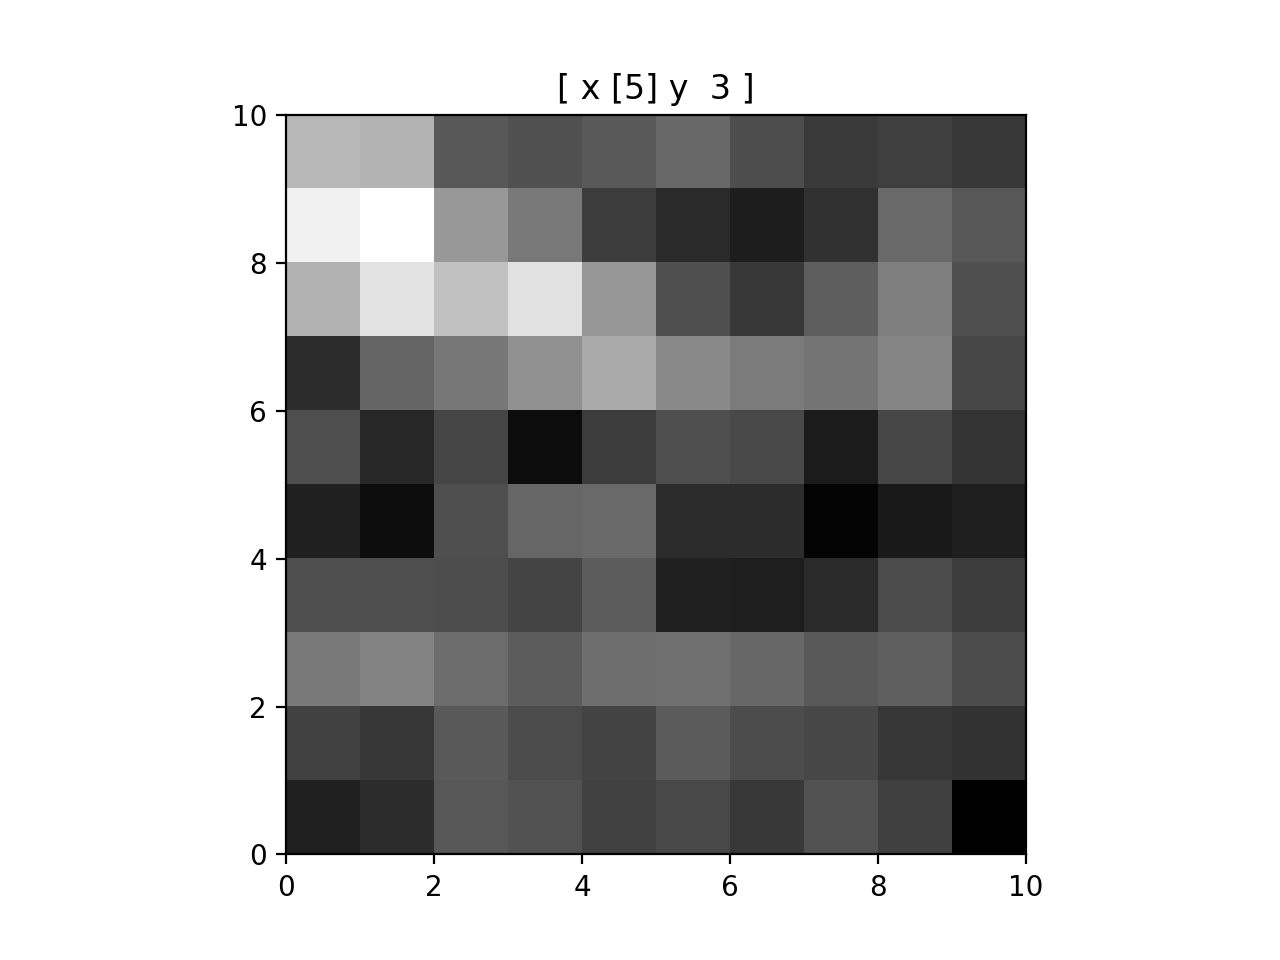

In [17]:
#10x10x10 voxel sample of the bottom right lung
intensity_bottom_sample = registered[130:140,60:70,70:80,:]
pl.ImagePlot(intensity_bottom_sample, x=0)

<IPython.core.display.Javascript object>


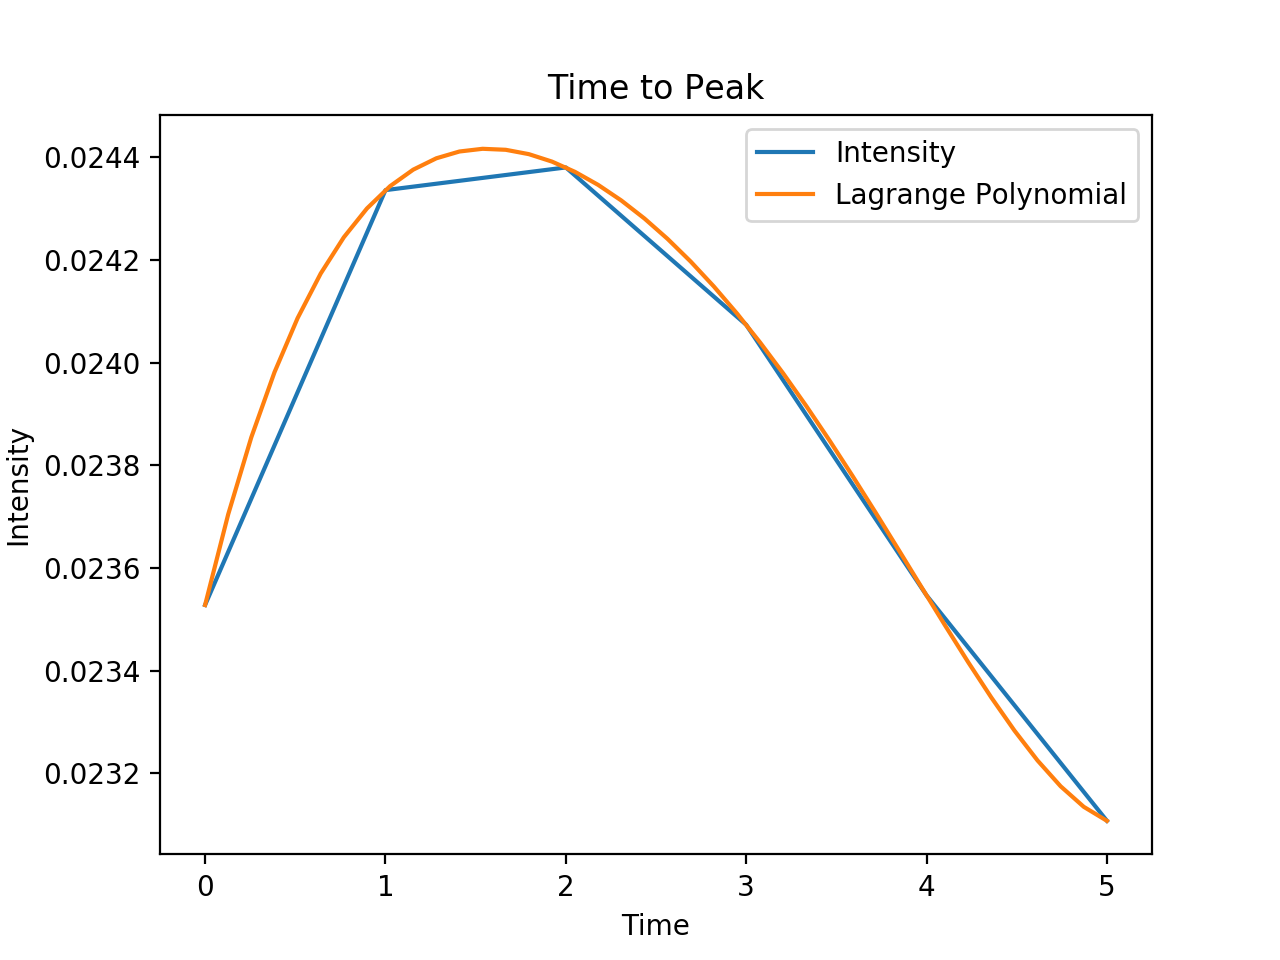

In [18]:
#Plot Time to Peak of bottom right sample
intensity_bottom_array = calculate_intensity(intensity_bottom_sample)
plot_TTP_langrange(intensity_bottom_array)

In [19]:
#Time to peak (x,y) values 
fitted_x, fitted_y = lagrange_curve_fitting(intensity_bottom_array, 30)
max_y = max(fitted_y)
ttp_x = fitted_x[np.argmax(fitted_y)]
print("x value:", ttp_x)
print("y value:", max_y)

x value: 1.5517241379310347
y value: 0.024416797672913423


In [20]:
#Calculate FWHM
peaks, _ = find_peaks(fitted_y)
results_half = np.asarray(peak_widths(fitted_y, peaks, rel_height=0.5)).flatten()
np.where(fitted_x == results_half[3])
print(results_half)
print(fitted_x)

[16.47084892  0.02397246  2.19223299 18.6630819 ]
[0.         0.17241379 0.34482759 0.51724138 0.68965517 0.86206897
 1.03448276 1.20689655 1.37931034 1.55172414 1.72413793 1.89655172
 2.06896552 2.24137931 2.4137931  2.5862069  2.75862069 2.93103448
 3.10344828 3.27586207 3.44827586 3.62068966 3.79310345 3.96551724
 4.13793103 4.31034483 4.48275862 4.65517241 4.82758621 5.        ]


<IPython.core.display.Javascript object>


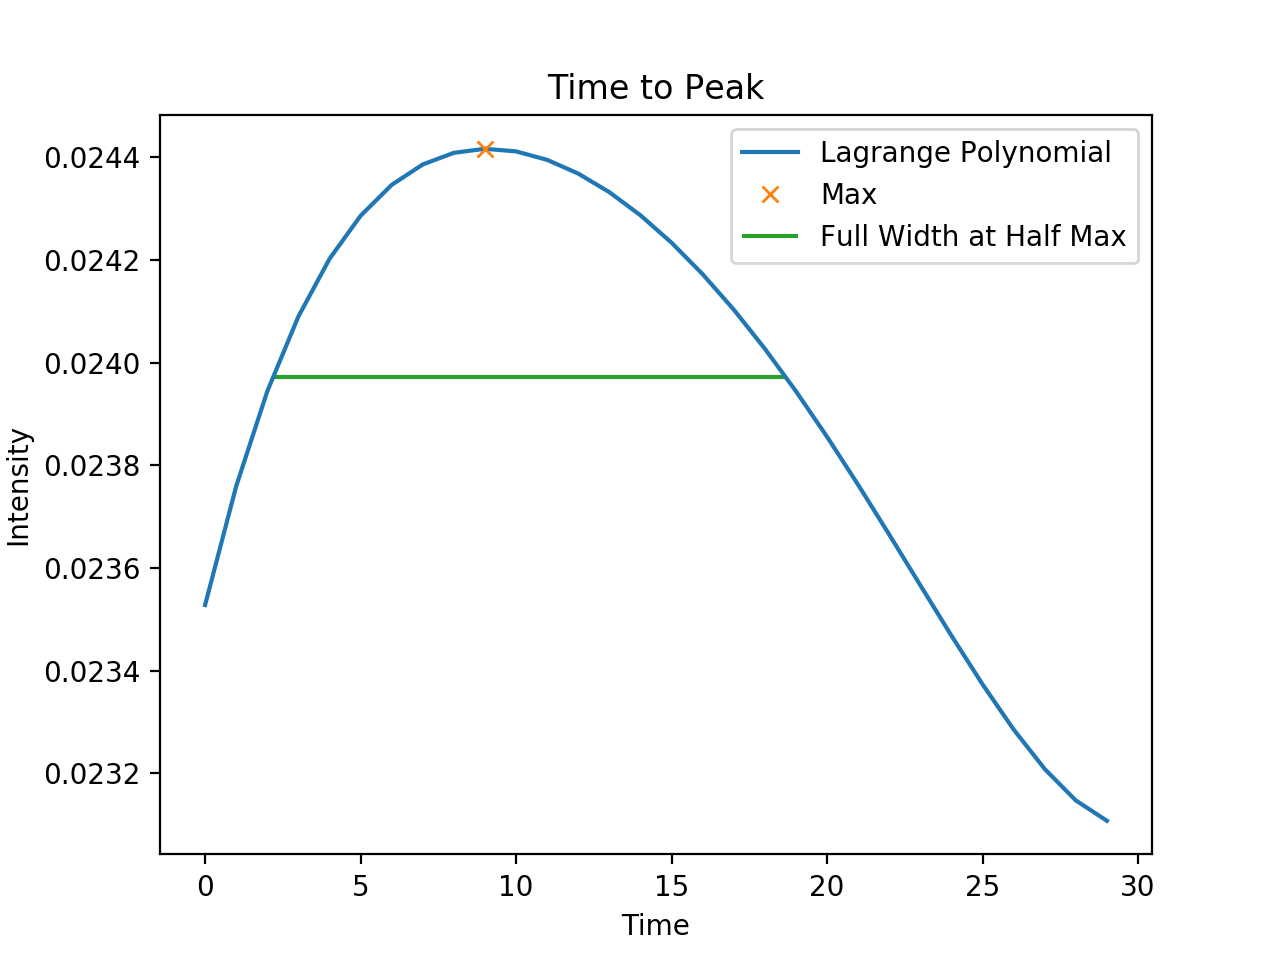

In [21]:
#Plot full width at half maximum
plot_full_width_half_max(intensity_bottom_array)

<IPython.core.display.Javascript object>


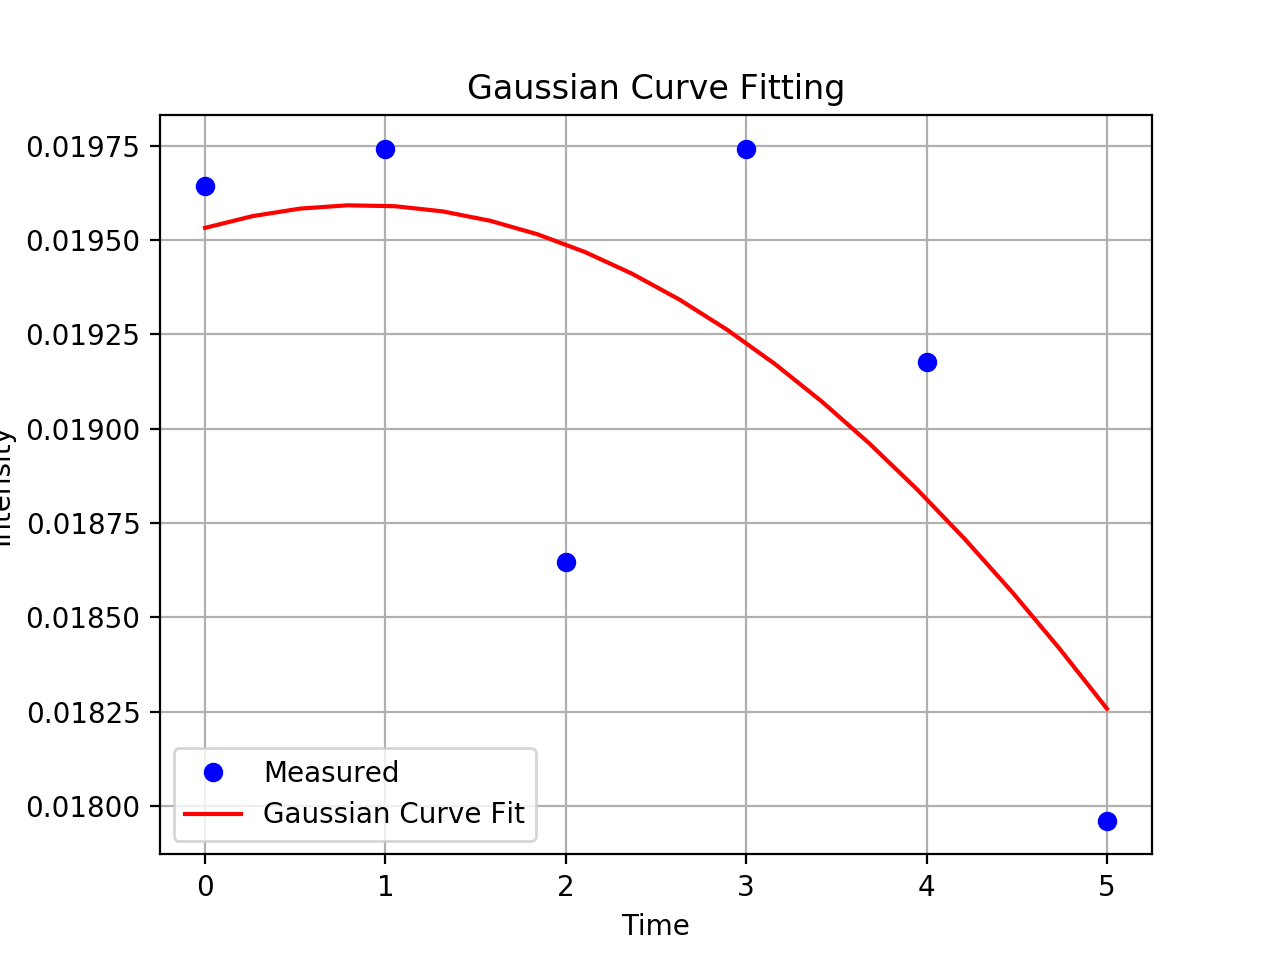

In [26]:
plot_gaussian_curve_fit(voxel_sample_4[32,16,20,:])

In [34]:
len(voxel_sample_4[32,16,20,:])

6

<IPython.core.display.Javascript object>


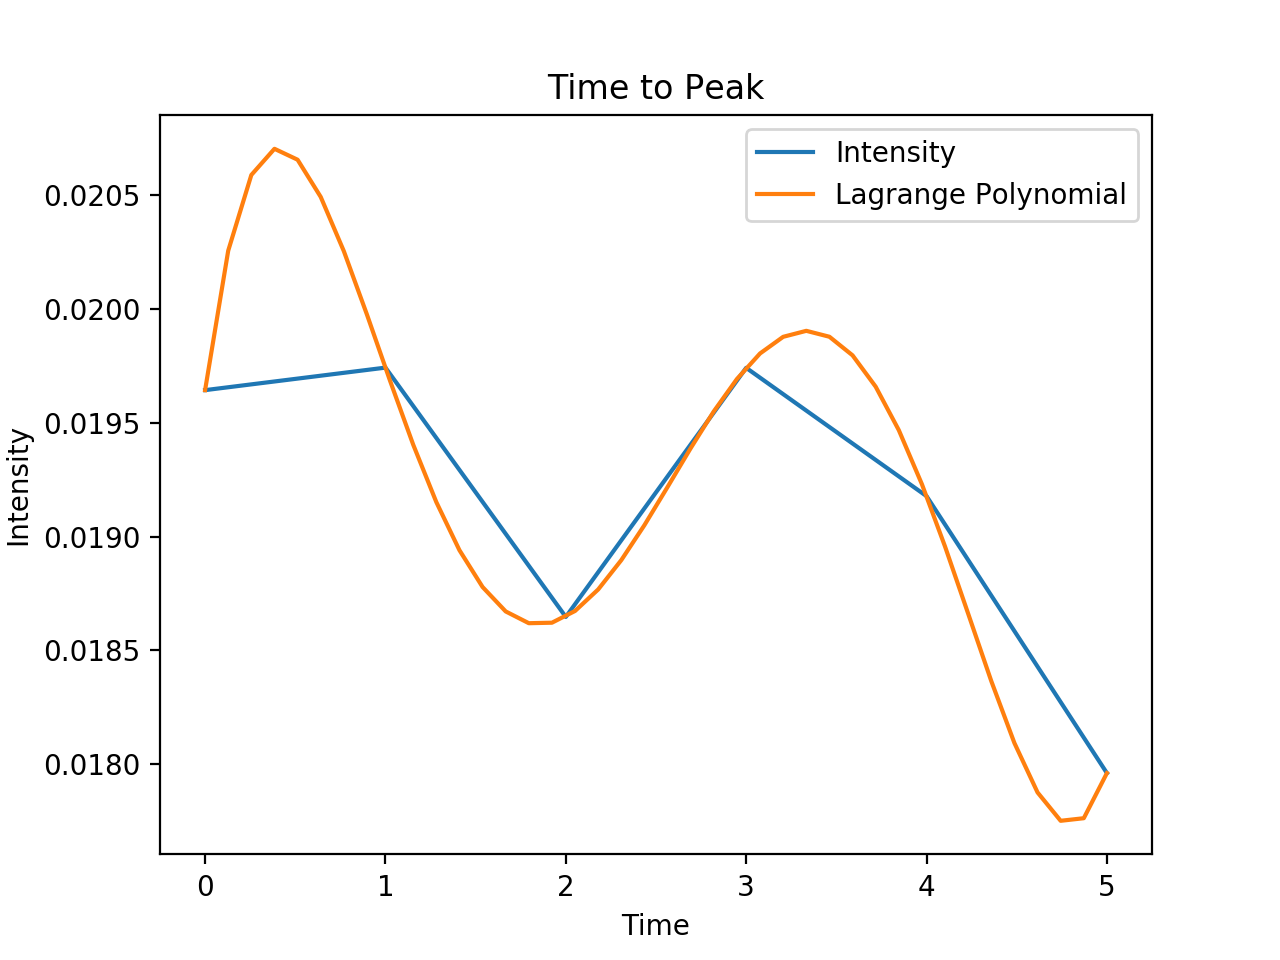

In [27]:
plot_TTP_langrange(voxel_sample_4[32,16,20,:])

<h1>Lung Mask Voxel Sample<h1>

In [28]:
#Generate a voxel sample given a size 
def voxel_sample(img, voxel_size):
    size = voxel_size
    x = img.shape[0] // size
    y = img.shape[1] // size
    z = img.shape[2] // size
    t = img.shape[3]
    sample = np.empty((x,y,z,t))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                for l in range(t):
                    sample[i, j, k, l] = np.mean(img[i*size:(i+1)*size, j*size:(j+1)*size, k*size:(k+1)*size, l:l+1])
    return sample

In [29]:
#Get lung mask from npy file
mask = mat['lung_mask']
mask.shape

(208, 128, 160)

<IPython.core.display.Javascript object>


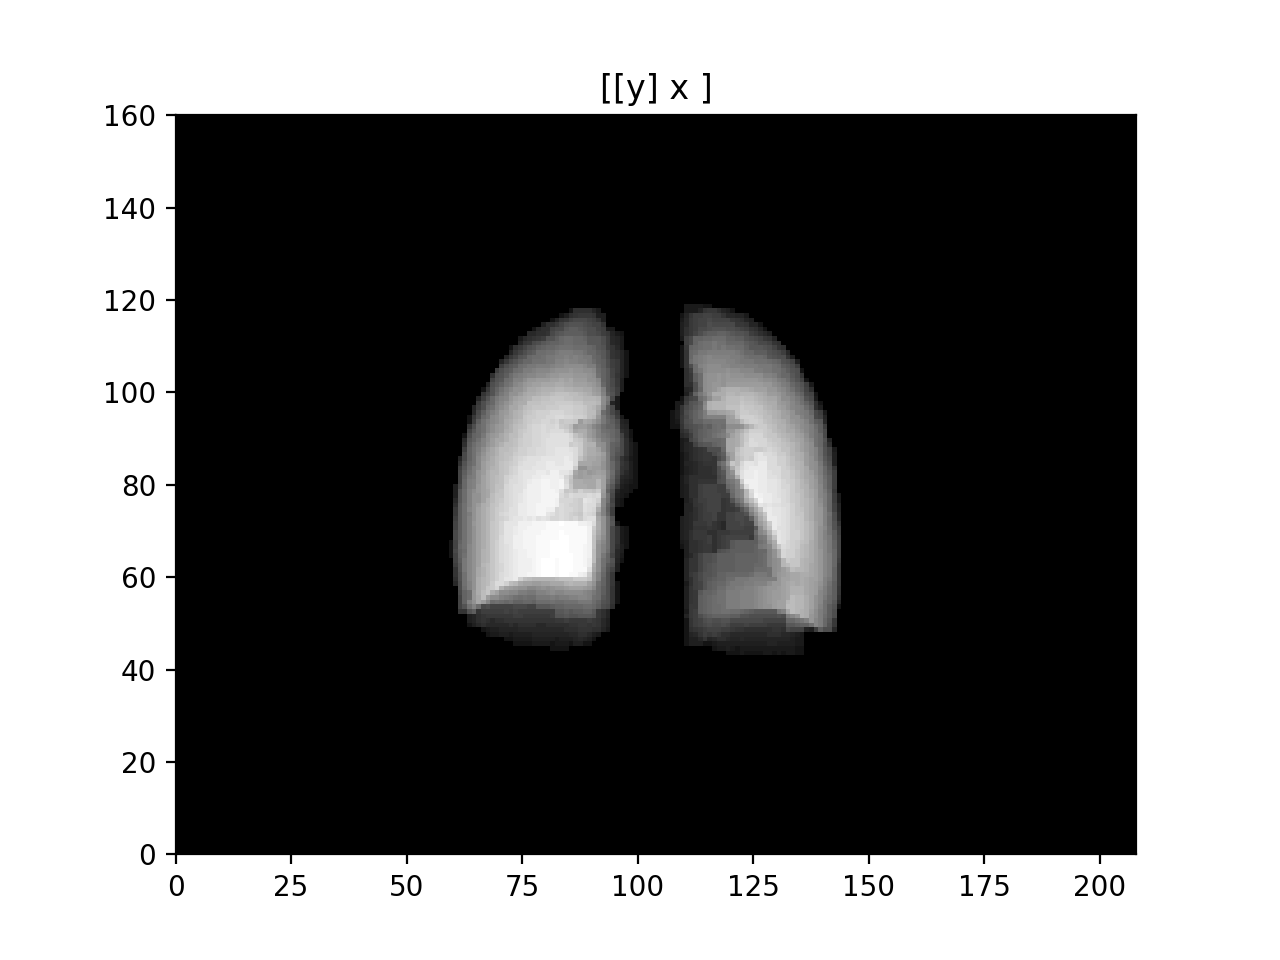

In [30]:
#Plot lung mask image
pl.ImagePlot(np.rot90(np.mean(mask, axis=1), k=3))

<IPython.core.display.Javascript object>


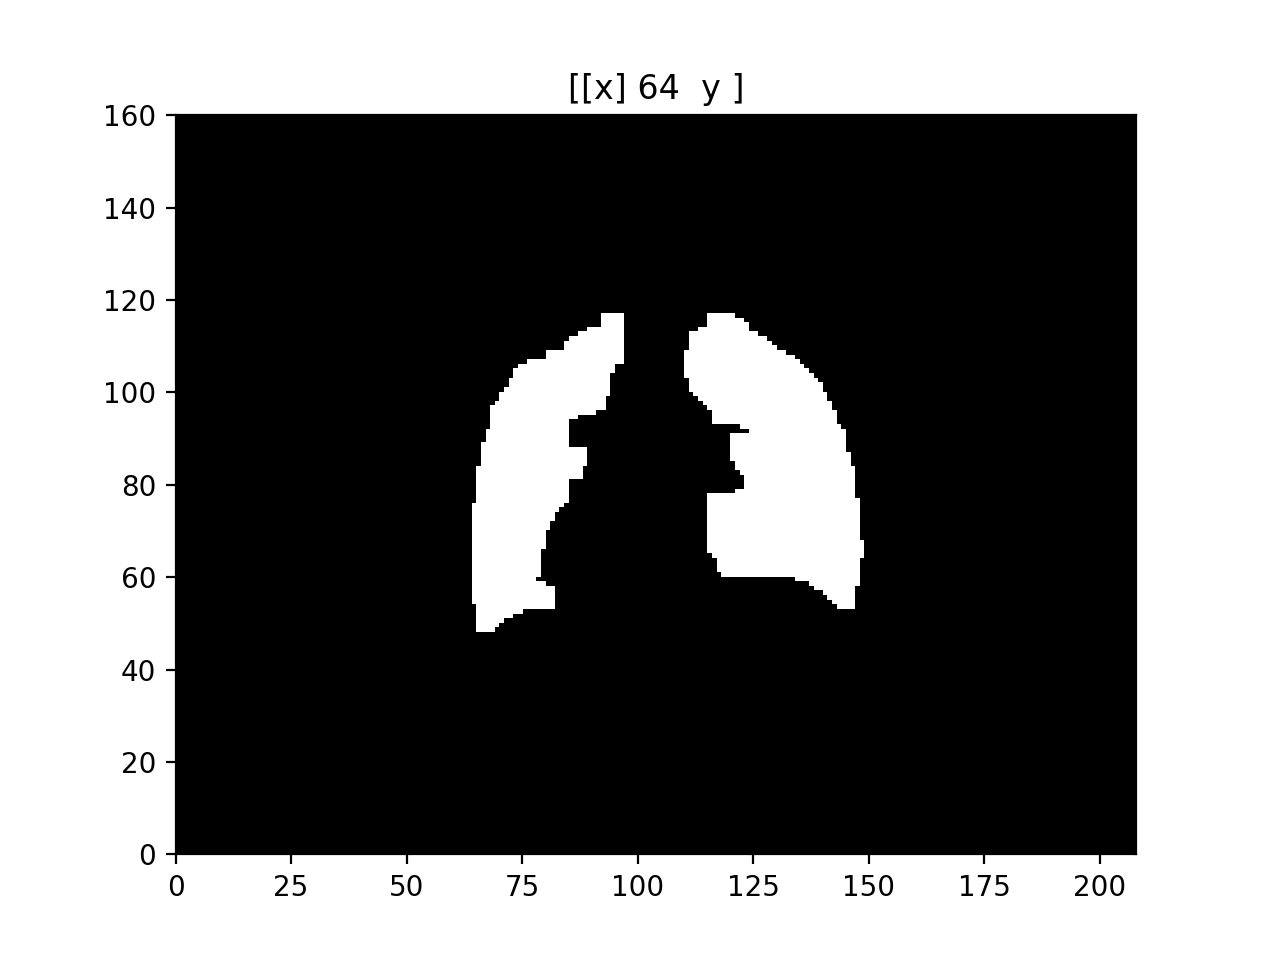

In [31]:
#Plot lung mask image
pl.ImagePlot(mask, x=0, y=2, mode='r')

<IPython.core.display.Javascript object>


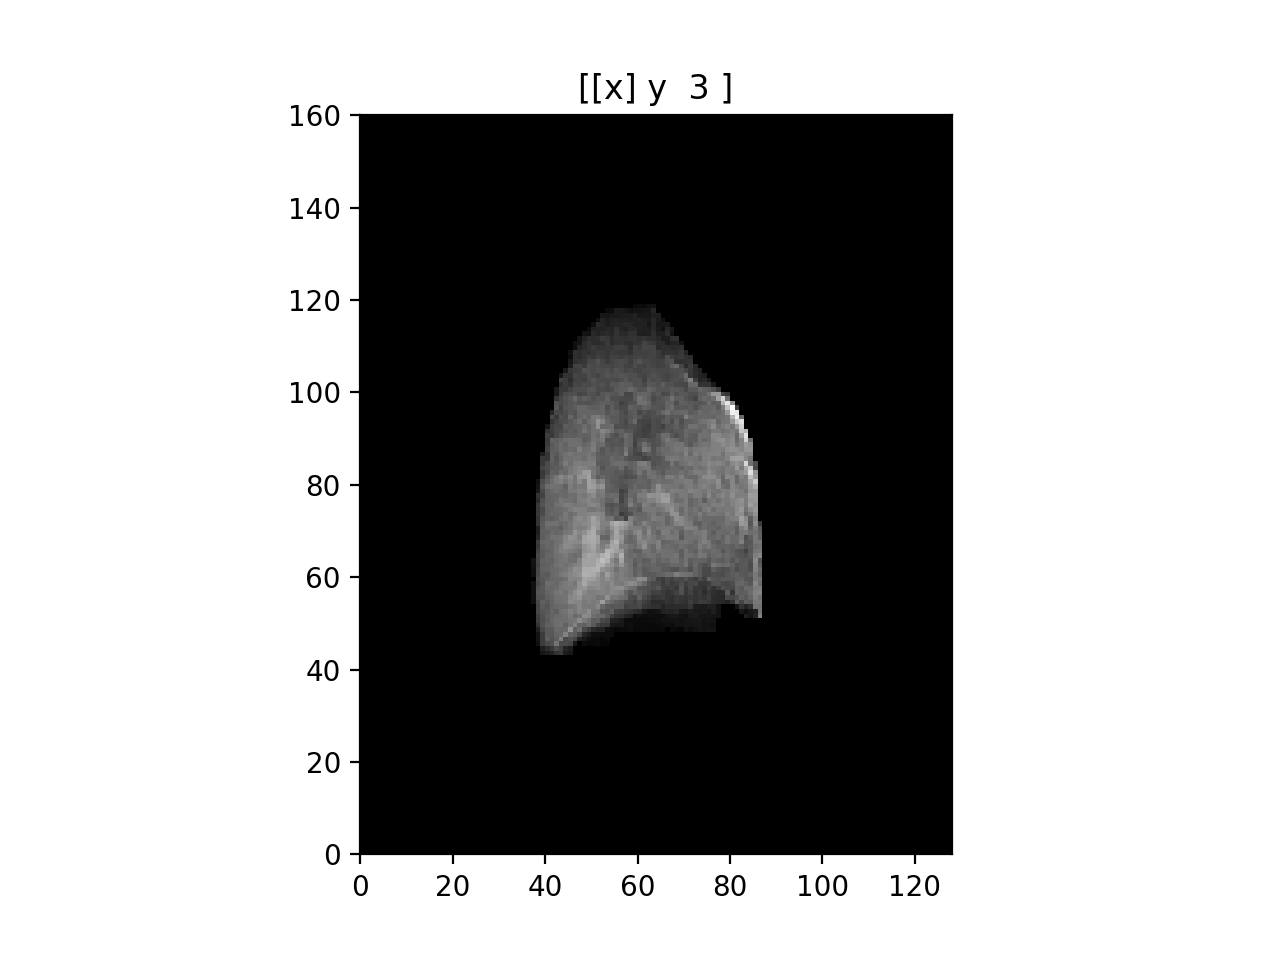

In [32]:
#Multiply lung mask with registered image 
lung_mask = np.empty((208, 128, 160, 6))
for i in range(6):
    lung_mask[:,:,:,i] = np.multiply(registered[:,:,:,i], mask)
pl.ImagePlot(lung_mask.mean(0), x=0)

<IPython.core.display.Javascript object>


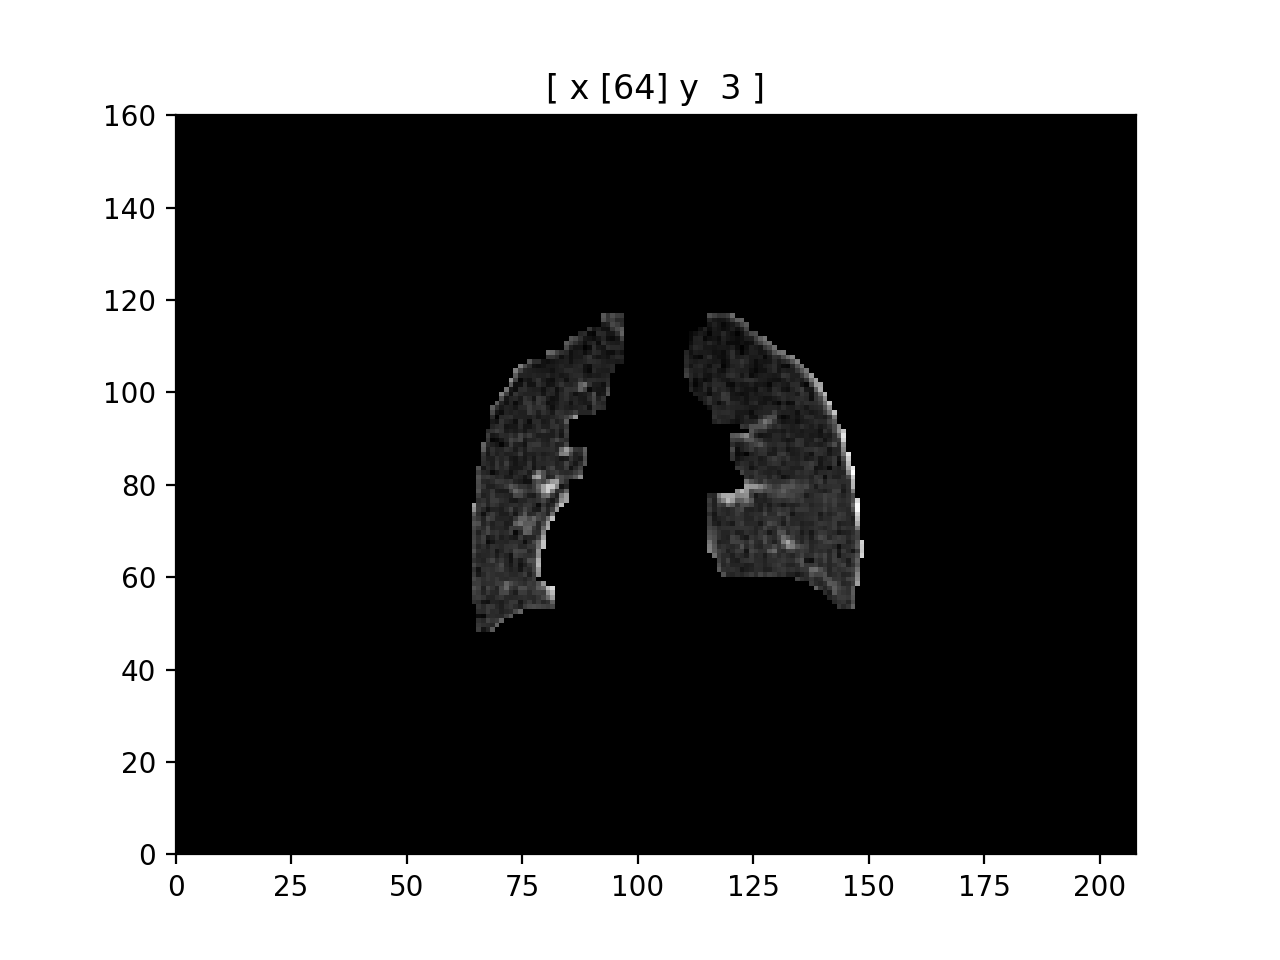

In [33]:
#Plot registered lung mask image
pl.ImagePlot(lung_mask, mode='r', x=0)

In [ ]:
#Calculate 16, 8, 4, 2 voxel sample
voxel_sample_8 = voxel_sample(lung_mask, 8)
voxel_sample_4 = voxel_sample(lung_mask, 4)
voxel_sample_2 = voxel_sample(lung_mask, 2)

<IPython.core.display.Javascript object>


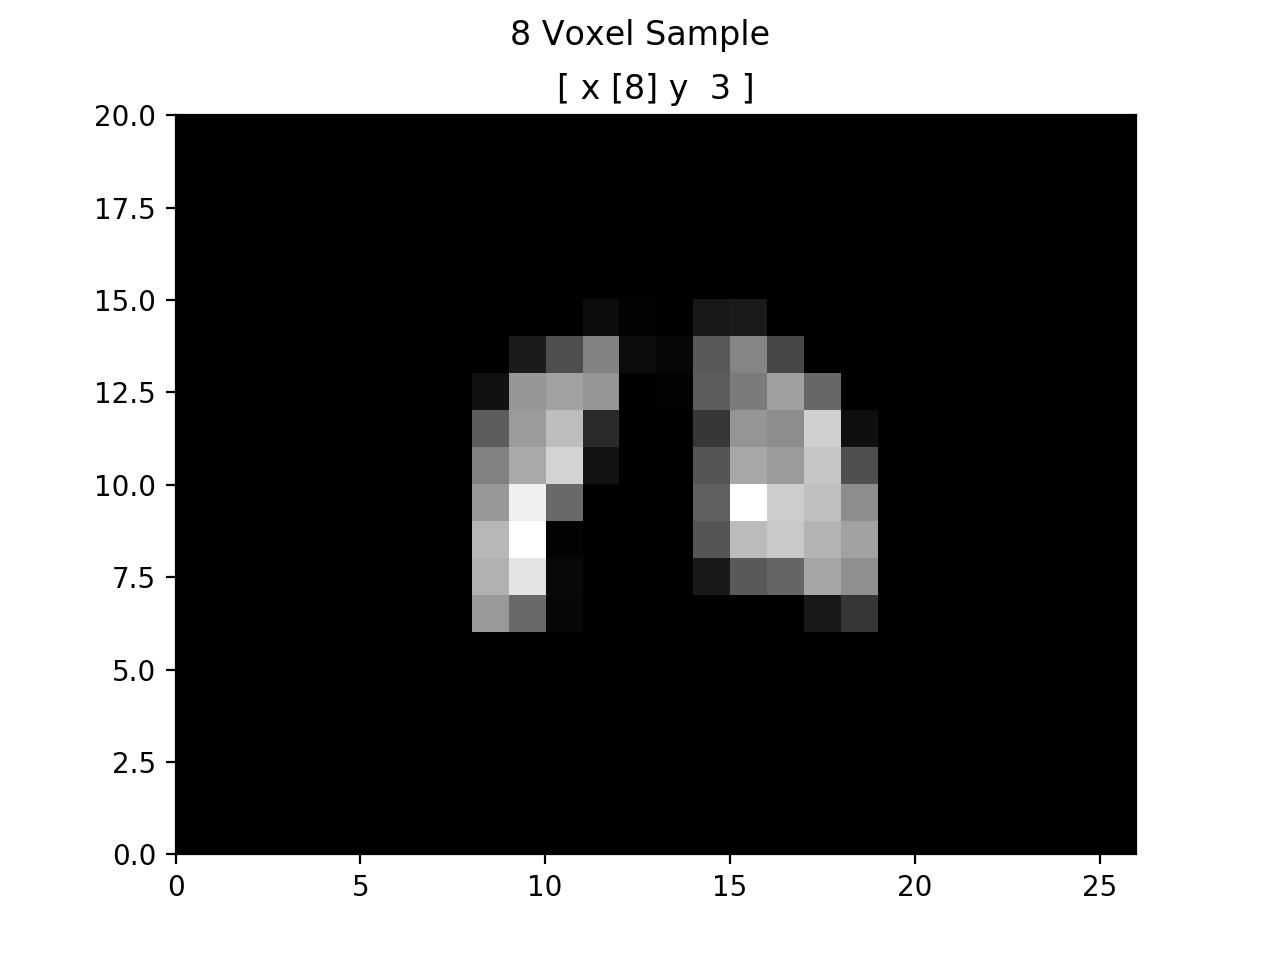

In [28]:
#Plot 8x8x8 voxel sample image
pl.ImagePlot(voxel_sample_8, x=0, title='8 Voxel Sample')

<IPython.core.display.Javascript object>


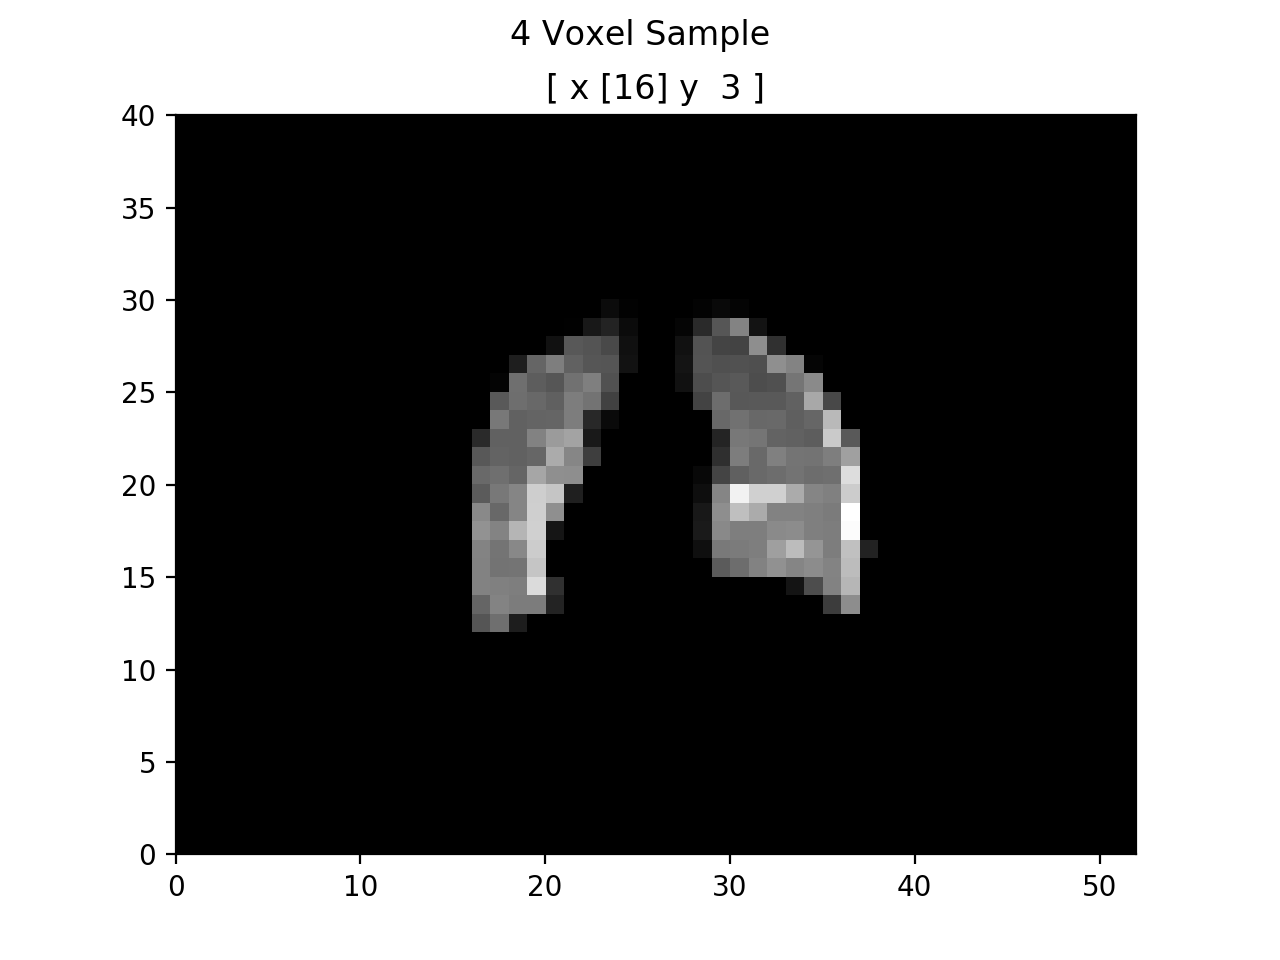

In [29]:
#Plot 4x4x4 voxel sample image
pl.ImagePlot(voxel_sample_4, x=0, title='4 Voxel Sample')

<IPython.core.display.Javascript object>


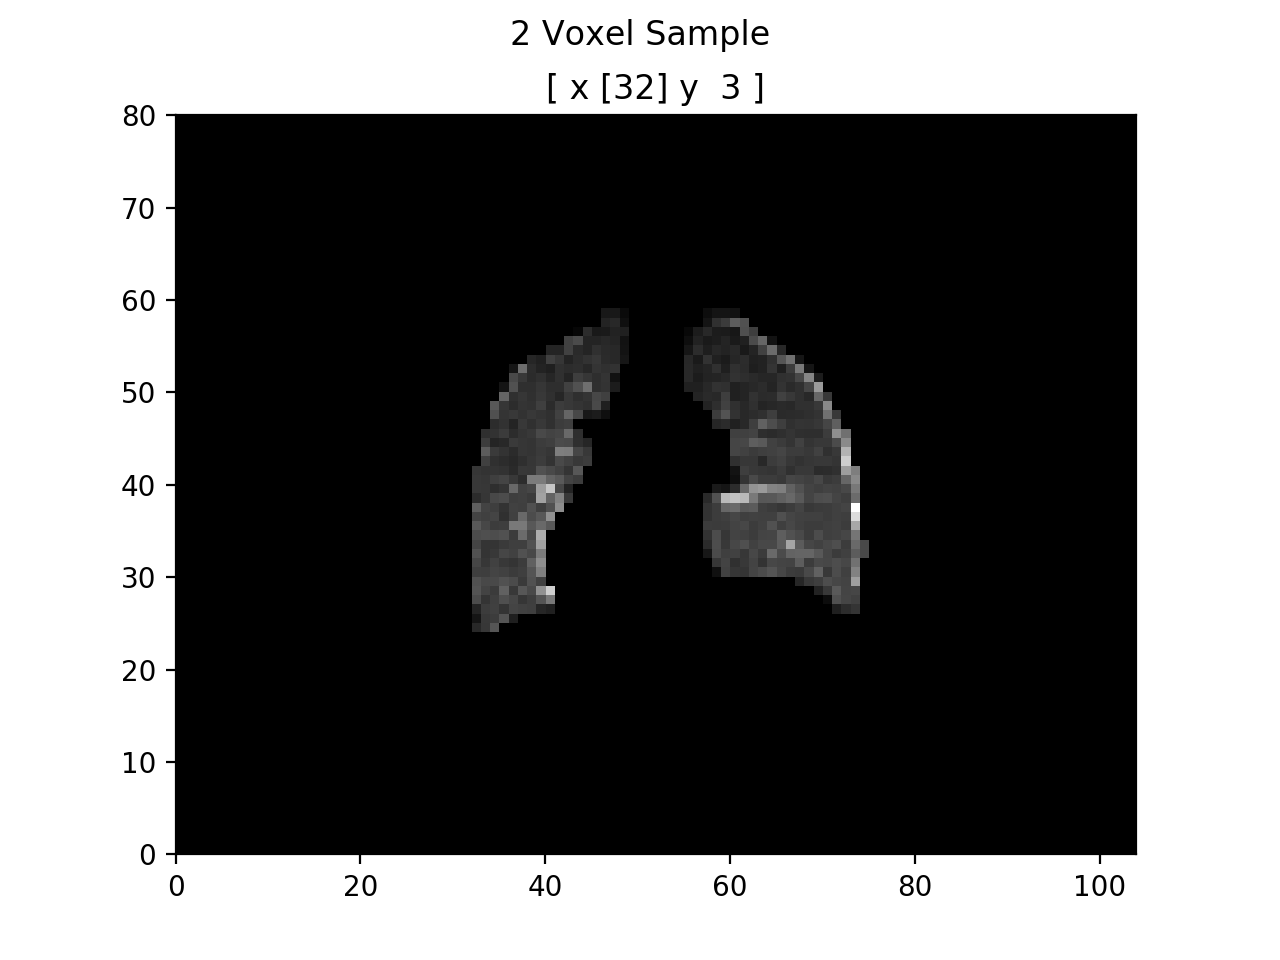

In [30]:
#Plot 2x2x2 voxel sample image
pl.ImagePlot(voxel_sample_2, x=0, title='2 Voxel Sample')

<h1> Color Map <h1>

<IPython.core.display.Javascript object>


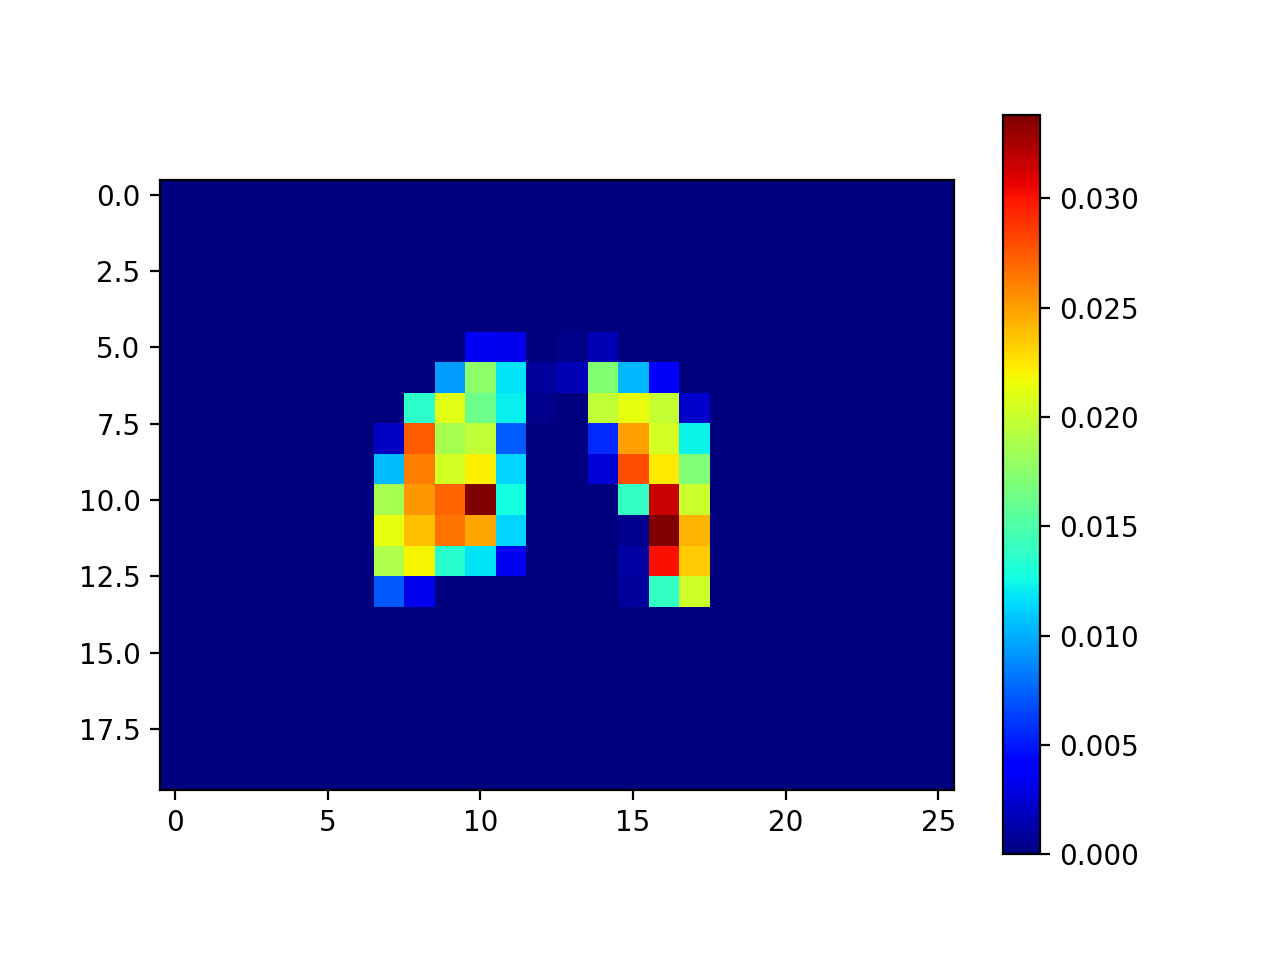

<IPython.core.display.Javascript object>


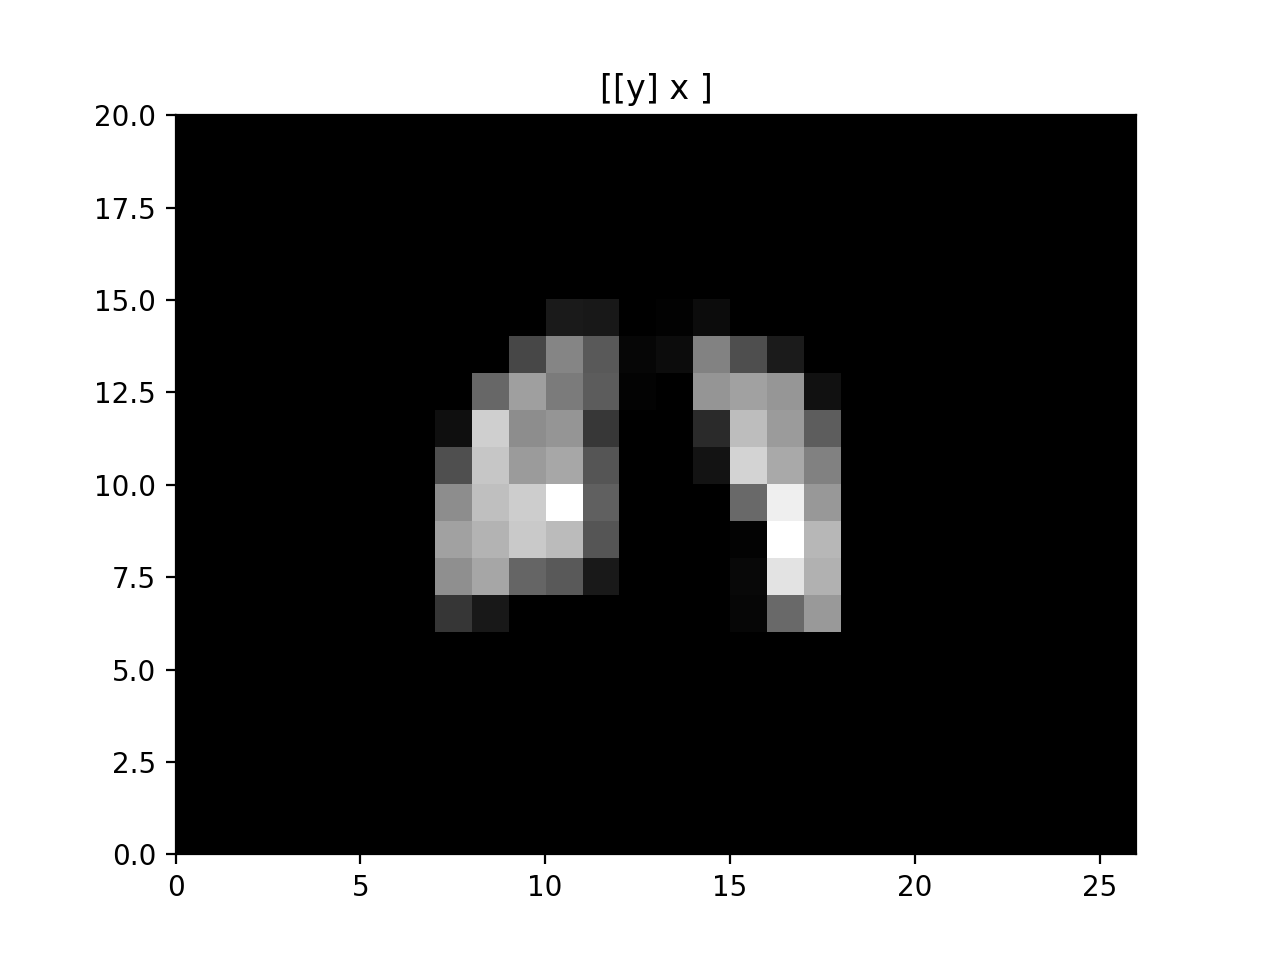

In [31]:
#Use matplotlib to generate colormap, compared to SigPy below
fig = plt.figure()
plt.imshow(np.flip(voxel_sample_8[:,8,:,3].T), cmap='jet')
plt.colorbar()

pl.ImagePlot(np.rot90(voxel_sample_8[:,8,:,3], k=3))

<IPython.core.display.Javascript object>


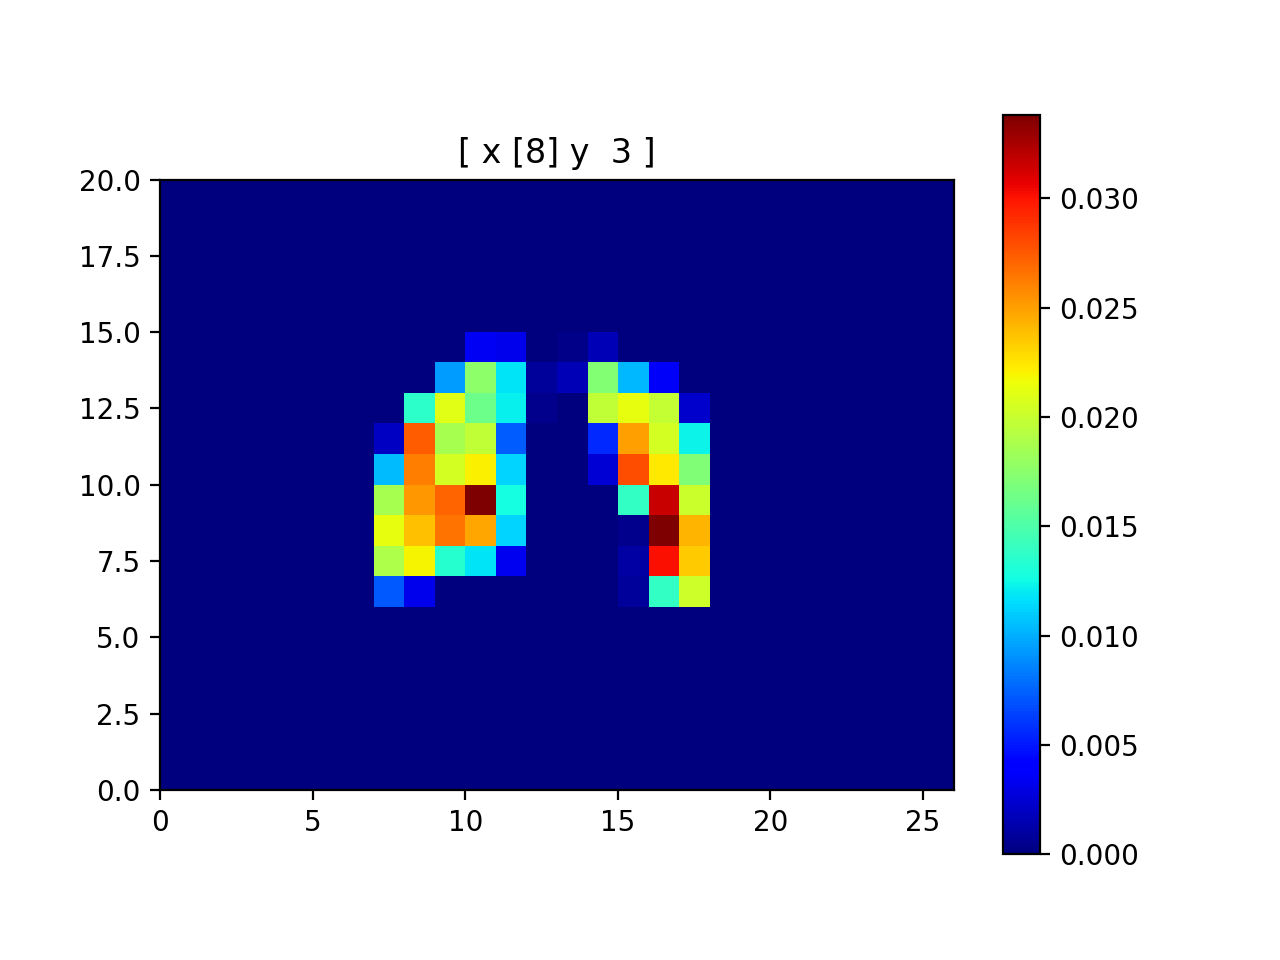

In [32]:
#Using SigPy to plot colormap
pl.ImagePlot(np.flip(voxel_sample_8, axis=0), colormap='jet', x=0)

<IPython.core.display.Javascript object>


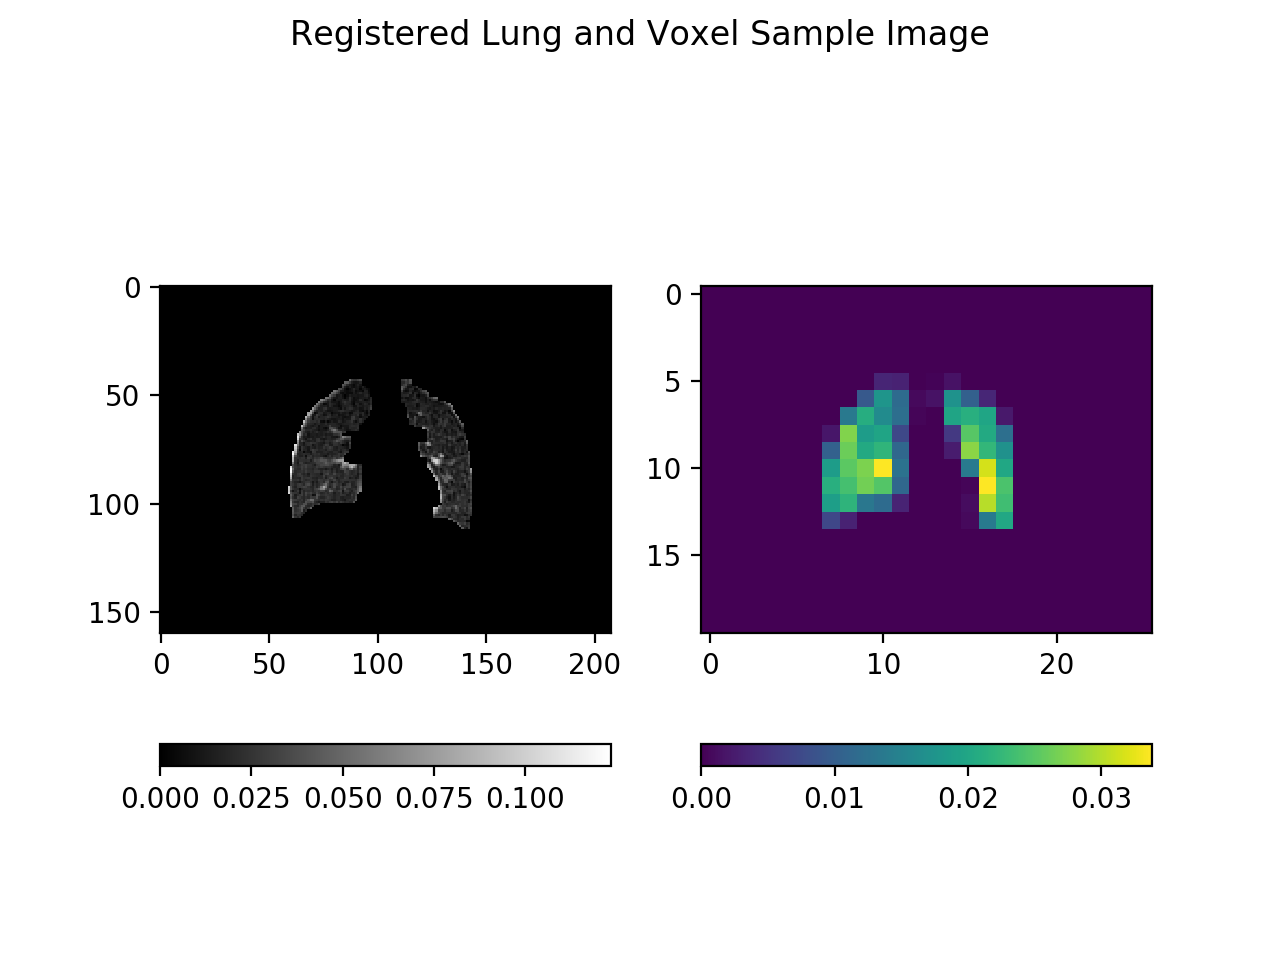

In [33]:
#Horizontally stack plots together
fig, axs = plt.subplots(1, 2)
cm = ['gray', 'viridis']
subplots = [lung_mask[:,64,:,3], voxel_sample_8[:,8,:,3]]
fig.suptitle('Registered Lung and Voxel Sample Image')

for col in range(2):
    ax = axs[col]
    pcm = ax.imshow(np.flip(subplots[col].T), cmap=cm[col])
    fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()

<IPython.core.display.Javascript object>


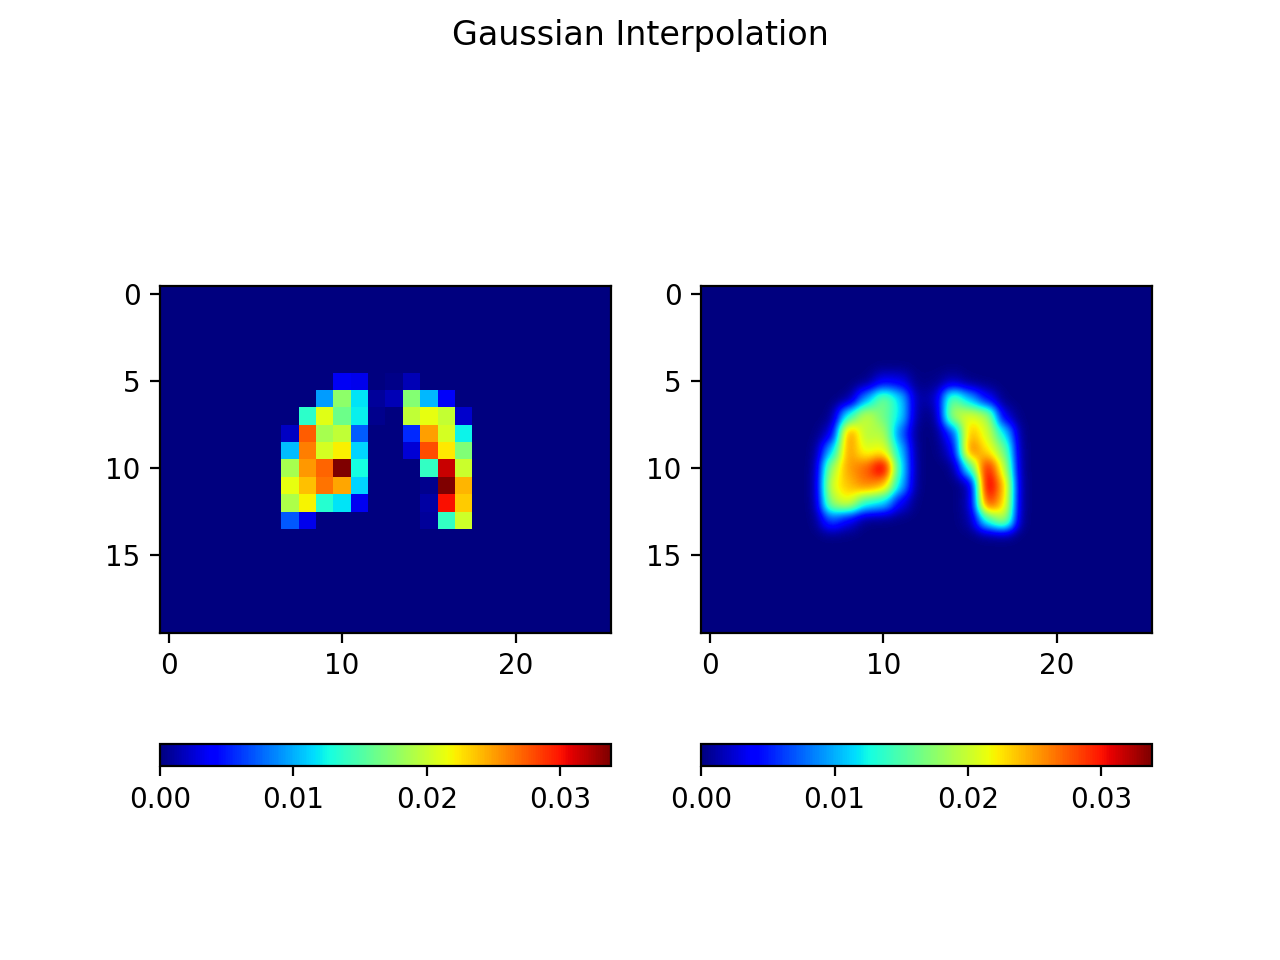

In [34]:
#Gaussian interpolations for imshow()
fig, axs = plt.subplots(1, 2)
subplots = [voxel_sample_8[:,8,:,3], voxel_sample_8[:,8,:,3]]
interp = [None, 'gaussian']
fig.suptitle('Gaussian Interpolation')

for col in range(2):
    ax = axs[col]
    pcm = ax.imshow(np.flip(subplots[col].T), cmap='jet', interpolation=interp[col])
    fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()

<h1>Peak Intensity with Color Map<h1>

In [35]:
#Look at the delta betwen max and min 
#normalize max to 1

In [36]:
#Calculates peak intensity value 
def calculate_peak_intensity(img):
    max_index = np.argmax(img, axis=3)
    sample = np.empty(max_index.shape)
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    indx = max_index[i,j,k]
                    sample[i, j, k] = img[i, j, k, indx]
    return sample

In [ ]:
#Calculate peak intensity for 8, 4 voxel samples
peak_intensity_8 = calculate_peak_intensity(voxel_sample_8)
peak_intensity_4 = calculate_peak_intensity(voxel_sample_4)

/home/darrenhsu/anaconda3/lib/python3.7/site-packages/sigpy/plot.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure()


<IPython.core.display.Javascript object>


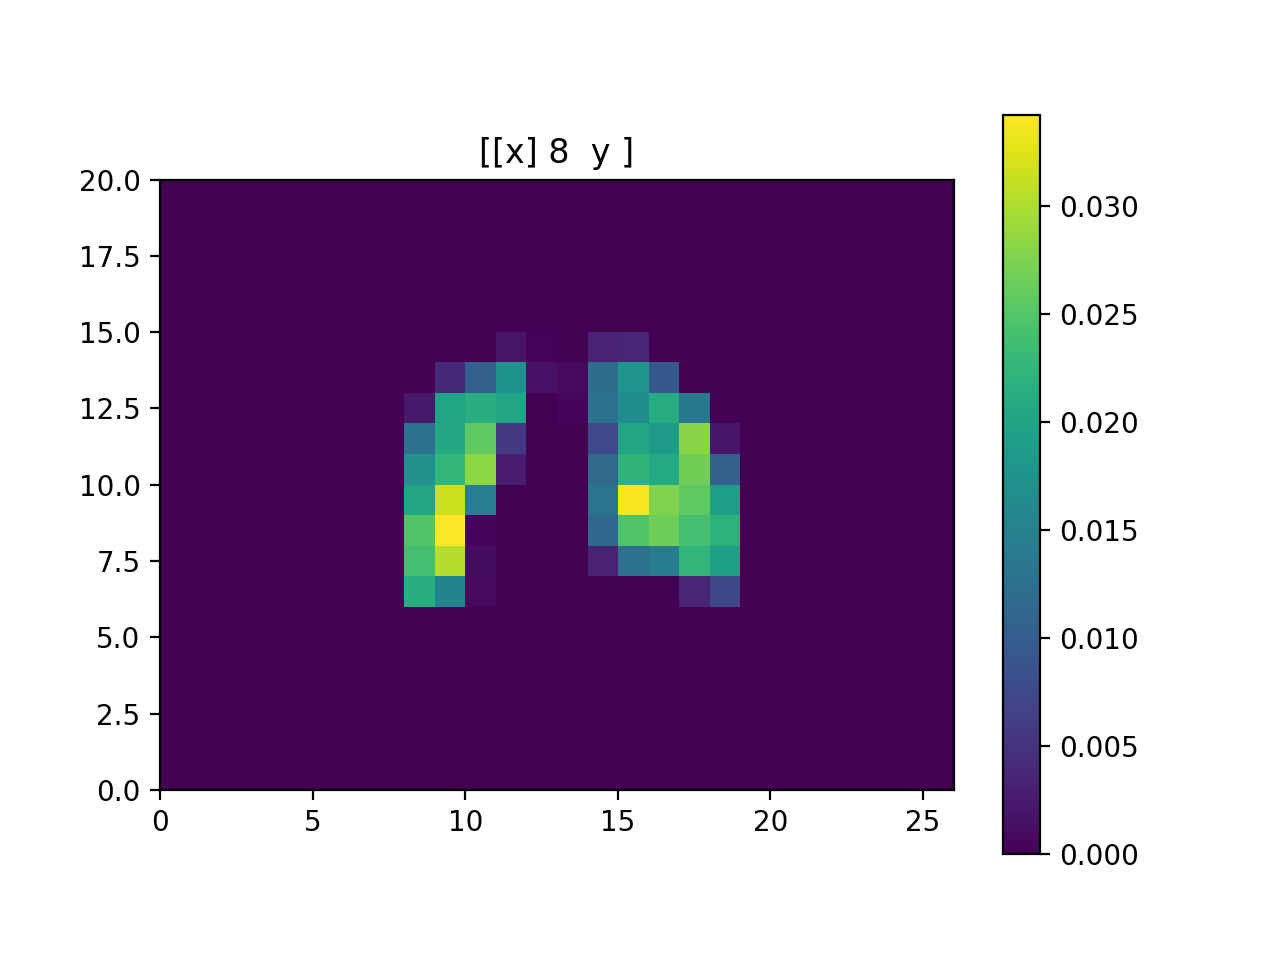

In [37]:
#Plot peak intensity of a 8 voxel sample
pl.ImagePlot(peak_intensity_8, x=0, y=2, colormap ='viridis')

<IPython.core.display.Javascript object>


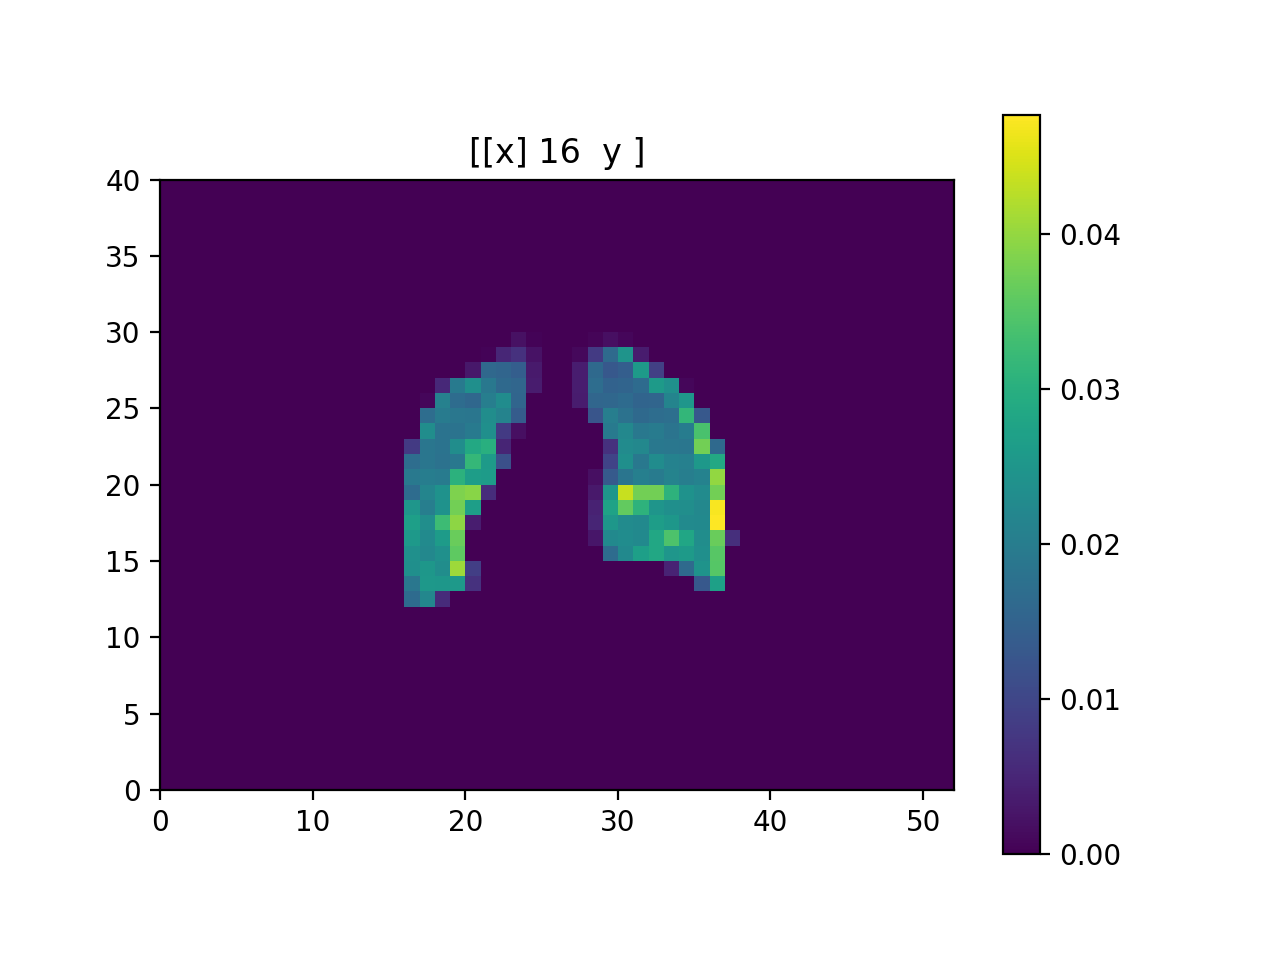

In [38]:
#Plot peak intensity of a 4 voxel sample
pl.ImagePlot(peak_intensity_4, x=0, y=2, colormap ='viridis')

<h1>Time to Peak with Color Map<h1>

In [12]:
#Calculates time to peak
#Investigate if np.apply_over_axis or np.apply_along_axis can speed up algorithm 
def calculate_time_to_peak(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    fitted_x, fitted_y = lagrange_curve_fitting(slice_1D, 20)
                    max_y = max(fitted_y)
                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

In [13]:
#Validate time to peak algorithm by plotting
def validate_ttp_sample(x, y, sample):
    sample_array = sample[x,16,y,:]
    
    plot_TTP_langrange(sample_array)

    fitted_x, fitted_y = lagrange_curve_fitting(sample_array, 20)
    max_y = max(fitted_y)
    ttp_x = fitted_x[np.argmax(fitted_y)]

    print("Time to peak value of algorithm: ", ttp_x)
    print("Time to peak value of image: ", time_to_peak_4[x,16,y])
    print("isSame: ", time_to_peak_4[x,16,y] == ttp_x)

In [ ]:
#Calculate time to peak for 8, 4 voxel samples
time_to_peak_8 = calculate_time_to_peak(voxel_sample_8)
time_to_peak_4 = calculate_time_to_peak(voxel_sample_4)

In [ ]:
#gaussian or lower order polynomial 

<IPython.core.display.Javascript object>


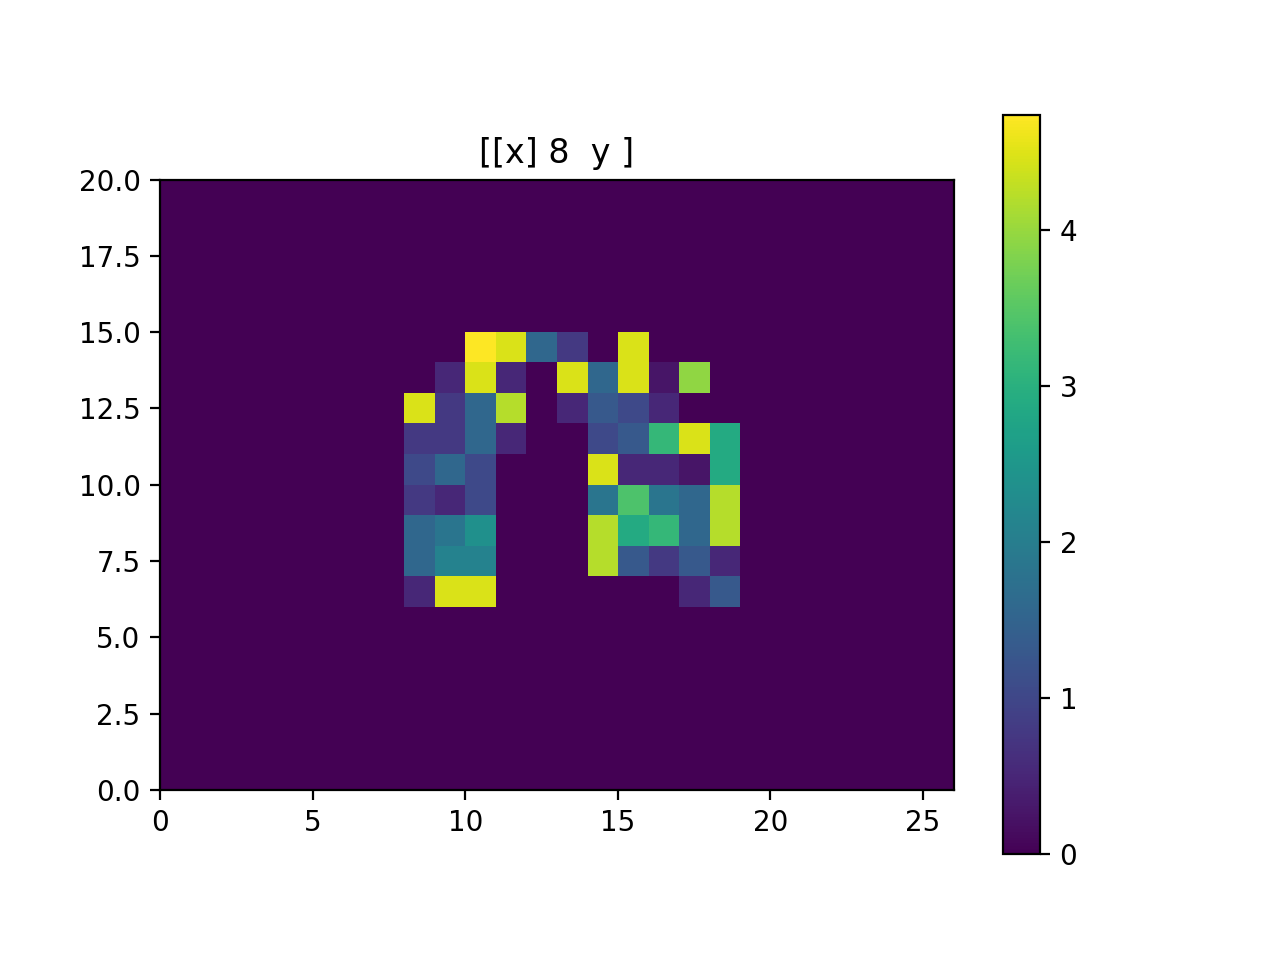

In [41]:
#Plot time to peak of a 8 voxel sample
pl.ImagePlot(time_to_peak_8, x=0, y=2, colormap ='viridis')

<IPython.core.display.Javascript object>


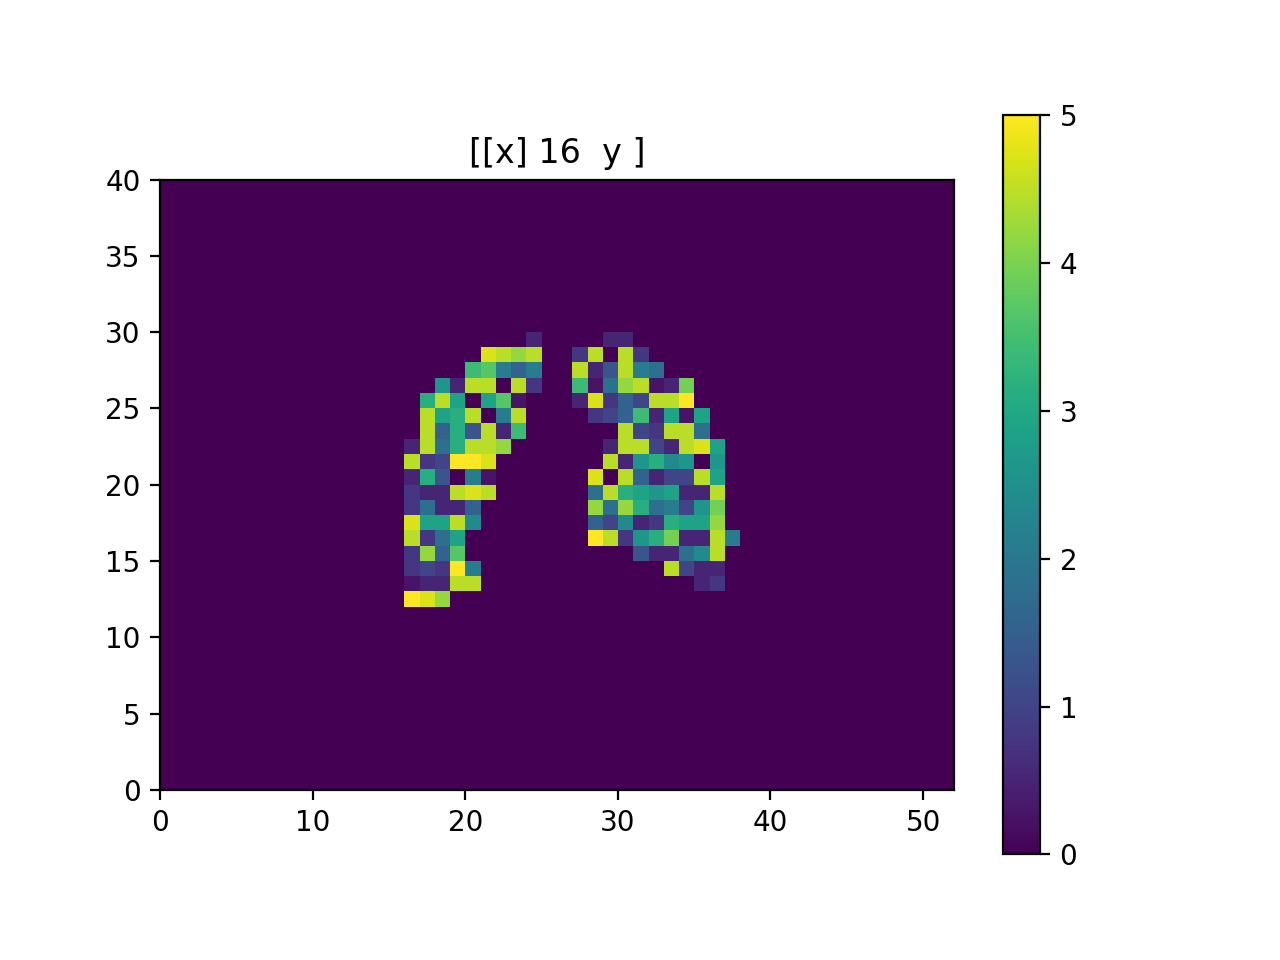

In [42]:
#Plot time to peak of a 4 voxel sample
pl.ImagePlot(time_to_peak_4, x=0, y=2, colormap ='viridis')

/home/darrenhsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


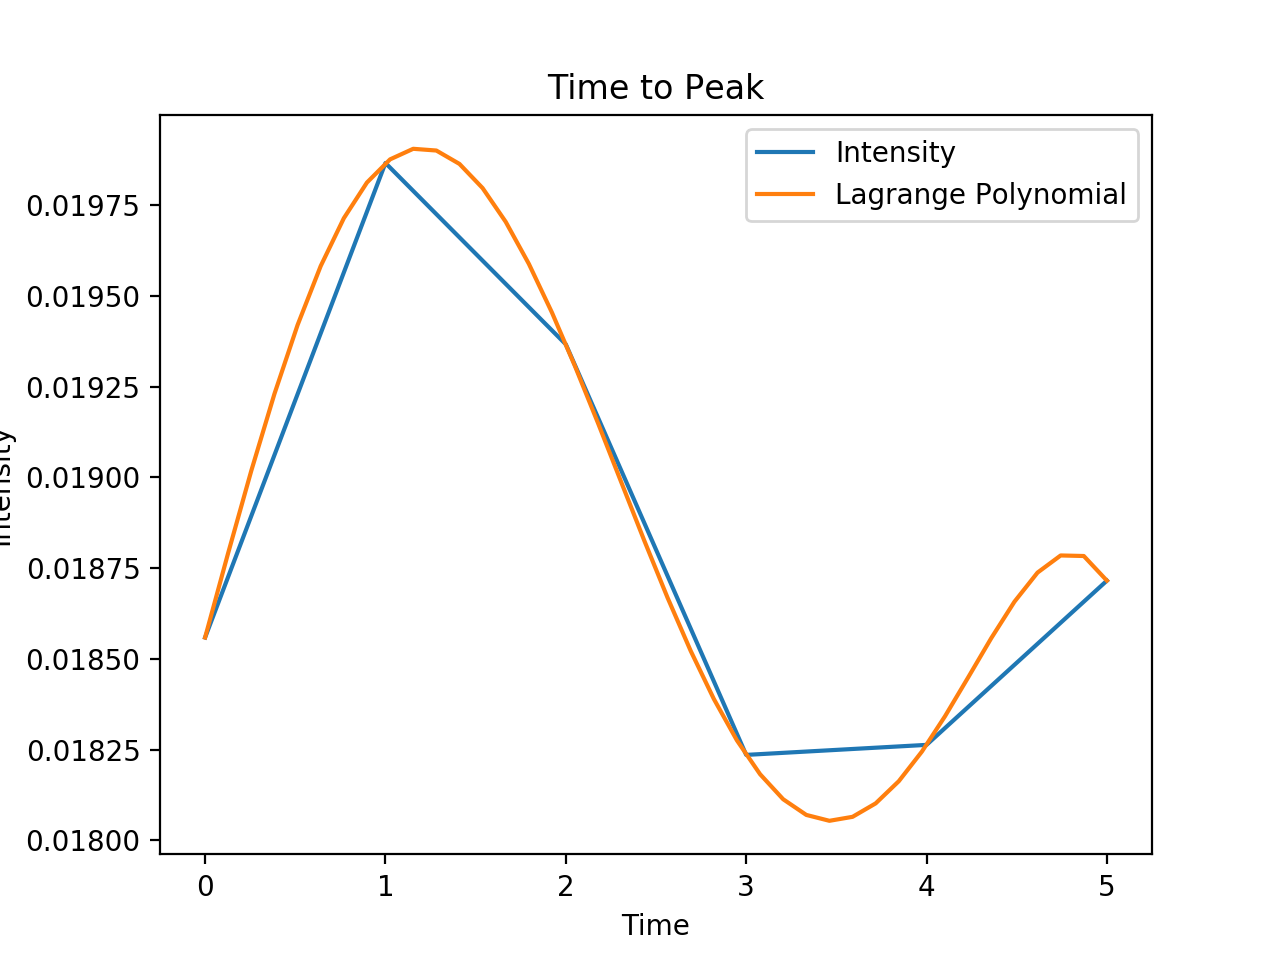

Time to peak value of algorithm:  1.3157894736842104
Time to peak value of image:  1.3157894736842104
isSame:  True


In [43]:
validate_ttp_sample(18,20, voxel_sample_4)

<h1>Full Width at Half Max Color Map<h1>

In [44]:
#Calculate full width half max with lagrange curve fitting
#Investigate if np.apply_over_axis or np.apply_along_axis can speed up algorithm 
def calculate_full_width_half_max_lagrange(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    fitted_x, fitted_y = lagrange_curve_fitting(slice_1D, 20)
                    peaks, _ = find_peaks(fitted_y)
                    results_half = peak_widths(fitted_y, peaks, rel_height=0.5)
                    if results_half[0].size == 0:
                        results_half = 0
                        sample[i, j, k] = results_half
                    else:
                        sample[i, j, k] = results_half[0][0]
    return sample

In [45]:
#Calculate full width half max
#Investigate if np.apply_over_axis or np.apply_along_axis can speed up algorithm 
def calculate_full_width_half_max(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    peaks, _ = find_peaks(slice_1D)
                    results_half = peak_widths(slice_1D, peaks, rel_height=0.5)
                    if results_half[0].size == 0:
                        results_half = 0
                        sample[i, j, k] = results_half
                    else:
                        sample[i, j, k] = results_half[0][0]
    return sample

In [ ]:
#Calculate full width half max with lagrange curve fitting
fwhm_lagrange_8 = calculate_full_width_half_max_lagrange(voxel_sample_8)
fwhm_lagrange_4 = calculate_full_width_half_max_lagrange(voxel_sample_4)

In [ ]:
#Calculate full width half max without lagrange curve fitting
fwhm_8 = calculate_full_width_half_max(voxel_sample_8)
fwhm_4 = calculate_full_width_half_max(voxel_sample_4)

/home/darrenhsu/anaconda3/lib/python3.7/site-packages/sigpy/plot.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure()


<IPython.core.display.Javascript object>


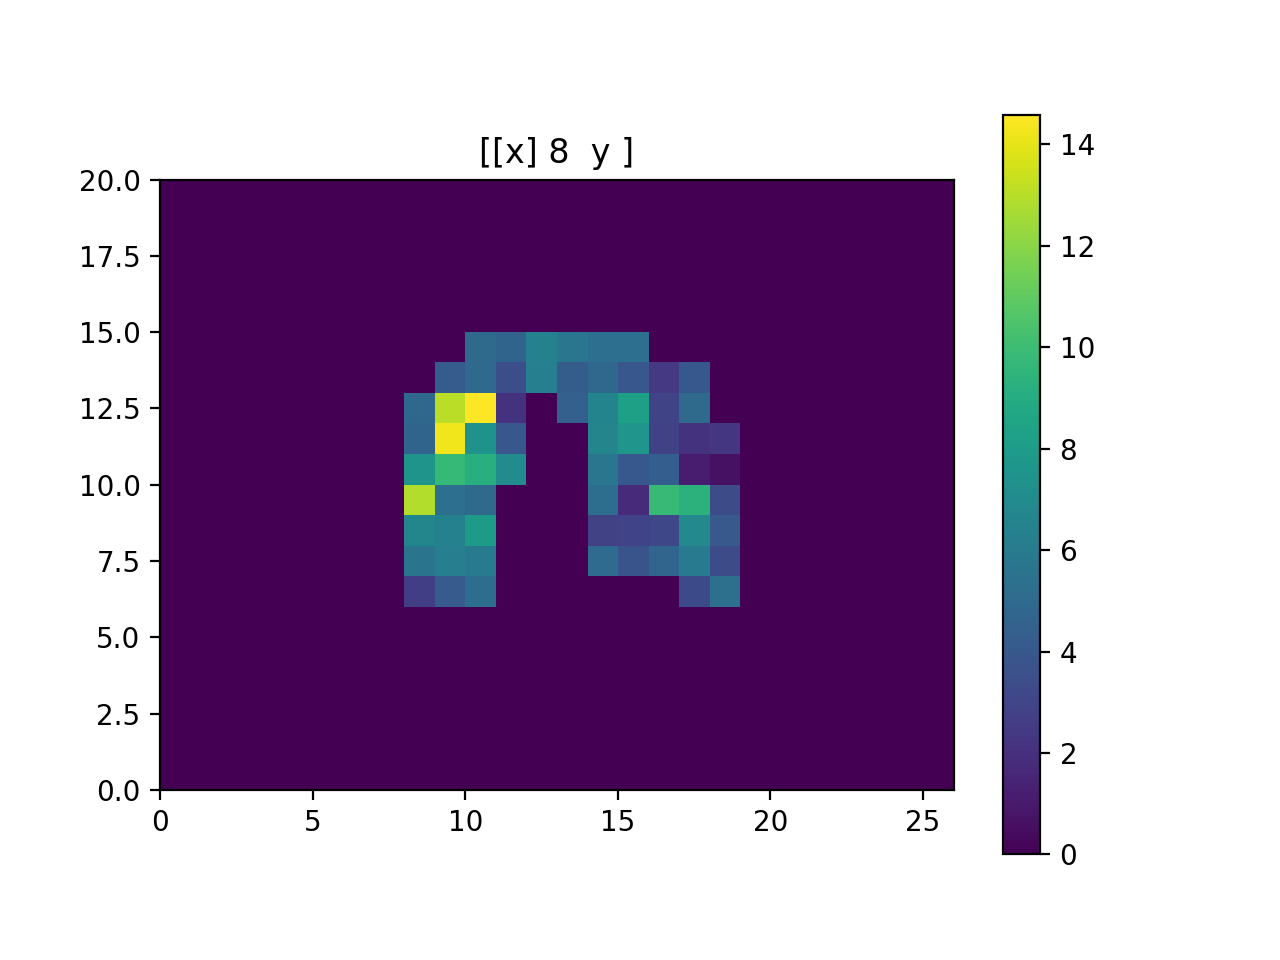

In [46]:
#Plot full width half max of a 8 voxel sample
pl.ImagePlot(fwhm_lagrange_8, x=0, y=2, colormap ='viridis')

<IPython.core.display.Javascript object>


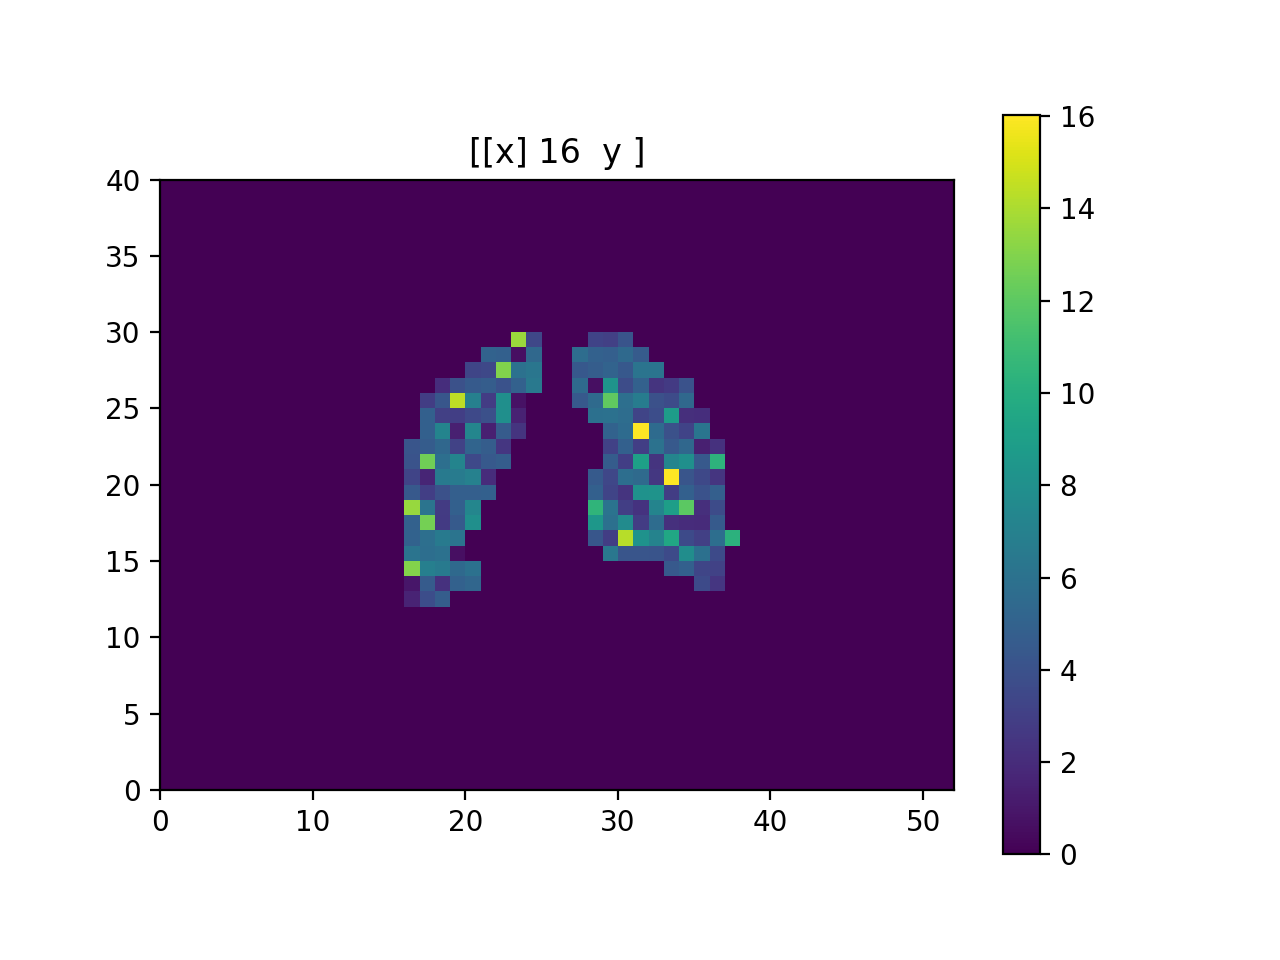

In [47]:
#Plot full width half max of a 4 voxel sample
pl.ImagePlot(fwhm_lagrange_4, x=0, y=2, colormap ='viridis')

<IPython.core.display.Javascript object>


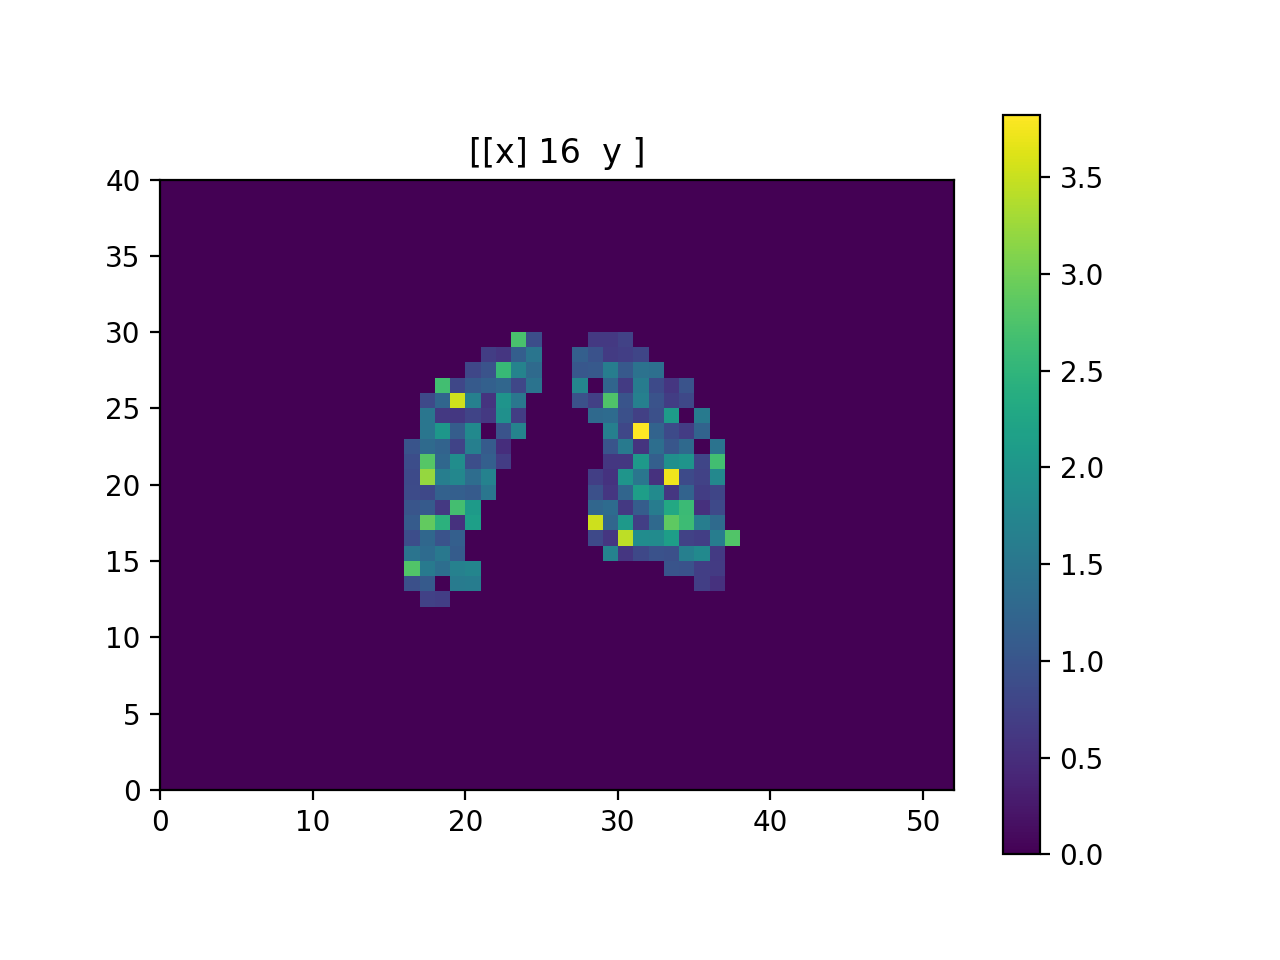

In [48]:
#Plot full width half max of a 4 voxel sample
pl.ImagePlot(fwhm_4, x=0, y=2, colormap ='viridis')

<h1> Saving and Loading Voxel Samples <h1>

In [23]:
#Build dictonary of voxel samples
voxel_samples = {
    'voxel_sample_8': voxel_sample_8,
    'voxel_sample_4': voxel_sample_4,
    'voxel_sample_2': voxel_sample_2,
    'peak_intensity_8': peak_intensity_8,
    'peak_intensity_4': peak_intensity_4,
    'time_to_peak_8': time_to_peak_8,
    'time_to_peak_4': time_to_peak_4,
    'fwhm_8': fwhm_8,
    'fwhm_4': fwhm_4,
    'fwhm_lagrange_8': fwhm_lagrange_8,
    'fwhm_lagrange_4': fwhm_lagrange_4
}

NameError: name 'voxel_sample_8' is not defined

In [ ]:
#Save dictonary to numpy file
np.save("voxel_samples.npy", voxel_samples)

In [10]:
#Load and deserialize numpy array 
voxel = np.load("voxel_samples.npy", allow_pickle=True).item()
voxel.keys()

dict_keys(['voxel_sample_8', 'voxel_sample_4', 'voxel_sample_2', 'peak_intensity_8', 'peak_intensity_4', 'time_to_peak_8', 'time_to_peak_4', 'fwhm_8', 'fwhm_4', 'fwhm_lagrange_8', 'fwhm_lagrange_4'])

In [11]:
#Load voxel samples to memory
voxel_sample_8 = voxel['voxel_sample_8']
voxel_sample_4 = voxel['voxel_sample_4']
voxel_sample_2 = voxel['voxel_sample_2']
peak_intensity_8 = voxel['peak_intensity_8']
peak_intensity_4 = voxel['peak_intensity_4']
time_to_peak_8 = voxel['time_to_peak_8']
time_to_peak_4 = voxel['time_to_peak_4']
fwhm_8 = voxel['fwhm_8']
fwhm_4 = voxel['fwhm_4']
fwhm_lagrange_8 = voxel['fwhm_lagrange_8']
fwhm_lagrange_4 = voxel['fwhm_lagrange_4']